## Preface

What are some recent tendencies in movies quality? Should we be afraid of film industry apocalypse? Given that brevity is the sister of talent, do more or less people with talent write movie overviews and taglines? Can revenues reveal which decades were really the greatest in cinema? Are there more sequels or movies with word "love" in title? If you would be interested in clues to some of these questions, you might consider reading further ;)

## Plan
1. To have reliable local validation, it is important to mimic the train/test split. So, let us focus on train vs. test EDA first. Along the way we would explore potential curiosities about film industry. As a helping step, we would perform adversarial validation.
2. Based on the EDA findings we would clean data, including filling of missing entries by querying TMDB API. 
3. Next, we would perform some feature engineering. 
4. <s>The task at hand has quite a few categorical features with high cardinality. Factorization machines have proven itself useful in problems with huge sparsity. We would use [libffm library](https://github.com/guestwalk/libffm) to create a field-aware factorization machine baseline.</s> *FFM turned out not to work well enough, please see previous kernel versions. On the bright side we learned how to work with the library which won a couple of competitions.*
5. Create an LightGBM baseline to predict movie box office. We would tune hyperparameters of the gradient boosting models by means of Bayesian optimization.


I would be very grateful for any comments, I'm looking forward to suggestions for improvement. At the same time I hope that some kaggler might enjoy findings from this notebook the way I did. 

## Loading libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
import cpi
from tqdm import tqdm_notebook as tqdm
import os
from collections import defaultdict
from functools import reduce
import string
from nltk.corpus import stopwords
stopwords_eng = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from scipy import stats
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
import joblib
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from copy import deepcopy
import subprocess
from statsmodels.stats.weightstats import _tconfint_generic
from shutil import rmtree

%matplotlib inline

## Train vs. test
### Loading data
I'm going to reuse data from the [kernel by Kamal Chhirang (ver 103)](https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat?scriptVersionId=11689723). In order not to repeat the same content as in the Kamal's kernel, I stored the data preprocessed by [Kamal](https://www.kaggle.com/kamalchhirang). The only differences compared to the Kamal's kernel were:
1. I omitted dummification and didn't drop categorical variables.
2. Instead of the original 

```df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')``` 

I used 

```df['meanruntimeByYear'] = df[['release_year']].merge(
df.groupby('release_year', as_index=False)['runtime'].agg(np.nanmean), on='release_year', how='left')['runtime']``` 

(Thanks to [Steve](https://www.kaggle.com/sun1994) I later learned about the concise alternative: ```df.groupby("release_year")["runtime"].transform('mean')``` :)). 

Also, I computed ratios like: ```df['runtime']/df["meanruntimeByYear"]```
3. To adjust for inflation, I used 
[this library](https://github.com/datadesk/cpi):
```df['budget_adjusted'] = (df['budget'].map(lambda x: [x]) + df['release_year'].map(lambda x: [x])).map(lambda budget_year: cpi.inflate(budget_year[0], budget_year[1]))```
4. I haven't transformed neither revenues, nor budgets to a log scale yet.
5. I haven't filled missing values.

In [2]:
train = pd.read_hdf('../input/tmdb-preprocessed/train_kamal.h5')
test = pd.read_hdf('../input/tmdb-preprocessed/test_kamal.h5')

### Was the organizers' train/test split time-based?

<Figure size 864x360 with 0 Axes>

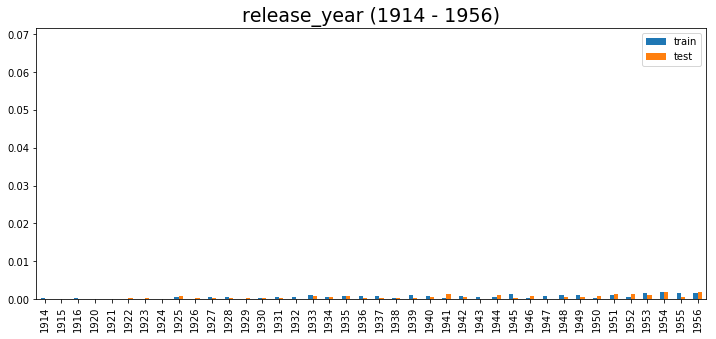

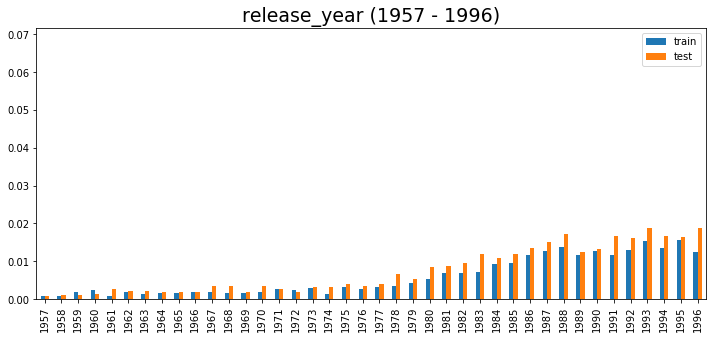

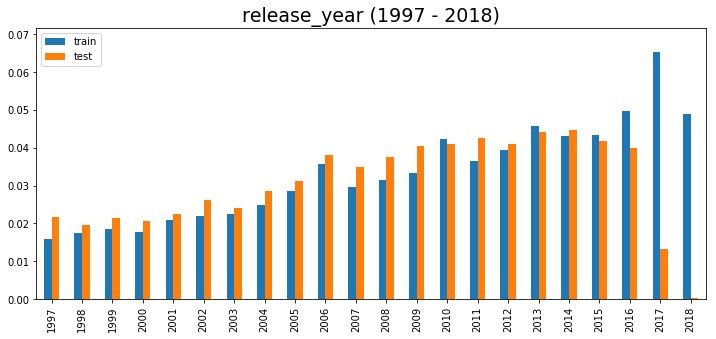

In [3]:
train['dataset'] = 'Train'
test['dataset'] = 'Test'
test['revenue'] = -1
data = pd.concat((train, test))

# helping function
def compare_barplots_categorical(df, first_group_bool_idx, second_group_bool_idx, include_sqrt=False, n_categories_in_figure=40, binned_categories=False):
    high_cardinality_cols = []
    for col in df.columns:
        plt.figure(figsize=(12,5))
        counts_train = df.loc[first_group_bool_idx, col].value_counts(dropna=False)
        counts_train /= np.sum(counts_train)
        counts_test = df.loc[second_group_bool_idx, col].value_counts(dropna=False)
        counts_test /= np.sum(counts_test)
        y_max = 1.1 * max(max(counts_train), max(counts_test))
        all_categories = sorted(df[col].unique()) if not binned_categories else sorted(df[col].unique(), key=lambda x: float(x[1:].split(',')[0]) if x != 'nan' else float('inf'))
        for category in all_categories:
            if category not in counts_train.index:
                counts_train[category] = 0
            if category not in counts_test.index:
                counts_test[category] = 0
        if len(all_categories) > 200:
            high_cardinality_cols.append([col, len(all_categories)])
        for pic_i, i in enumerate(range(0, len(all_categories), n_categories_in_figure)):
            categories_current = all_categories[i: i+n_categories_in_figure]
            all_counts = pd.DataFrame({'train': counts_train.loc[categories_current], 'test': counts_test.loc[categories_current]},
                                      index=categories_current)
            all_counts.plot.bar(rot=90, figsize=(12, 5))
            name = f' ({categories_current[0]} - {categories_current[-1]})' if len(all_categories) > n_categories_in_figure else ''
            plt.title(f'{col}' + name, fontsize=19)
            plt.ylim((0, y_max))
            if include_sqrt:
                all_counts = pd.DataFrame({'train': counts_train.loc[categories_current].map(lambda x: np.sqrt(np.sqrt(x))), 'test': counts_test.loc[categories_current].map(lambda x: np.sqrt(np.sqrt(x)))},
                                          index=categories_current)
                plt.figure()
                all_counts.plot.bar(rot=90, figsize=(12, 5))
                plt.title(f'{col} (sqrt)' + name, fontsize=19)
                plt.ylim((0, np.sqrt(np.sqrt(y_max))))
        if len(df.columns) > 1:
            plt.figure(figsize=(12, 1))
            plt.plot(range(10), np.ones(10))
    if len(high_cardinality_cols):
        print('High cardinality cols: ' + ', '.join(list(map(lambda x: x[0] + f' ({x[1]} vals)', high_cardinality_cols))))
        
compare_barplots_categorical(data[['release_year']], data['dataset']=='Train', data['dataset']=='Test')

From the Kamal's kernel we know that some movies were downloaded additionally. Let's check if the difference in the years 2017 and 2018 is given by the additional data.

In [4]:
def release_date_mapper(str_date):
    if str(str_date) == 'nan':
        return str_date
    month, day, year_candidate = str_date.split('/')
    year = int(year_candidate)
    if year < 100:
        if year <= 19: #imprecise, but good enough
            year += 2000
        else:
            year += 1900
    return month + '-' + day + '-' + str(year)

test_orig = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
test_orig['release_date'] = test_orig['release_date'].map(release_date_mapper)

train_orig = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
train_orig['release_date'] = train_orig['release_date'].map(release_date_mapper)
train_orig['dataset'] = 'Train'
test_orig['dataset'] = 'Test'
data_orig = pd.concat((train_orig, test_orig))

latest_release_date_test = pd.to_datetime(train_orig['release_date']).max()

print(f"Only {100*sum(pd.to_datetime(train_orig['release_date']) > latest_release_date_test)/len(train_orig):.1f} % of original training movies were release after the latest movie in test set.")

Only 0.0 % of original training movies were release after the latest movie in test set.


<Figure size 864x360 with 0 Axes>

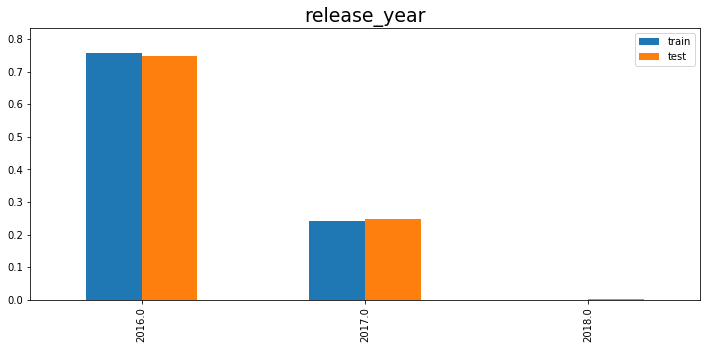

In [5]:
data_orig['release_year'] = data_orig['release_date'].map(lambda x: int(x.split('-')[-1]) if str(x) != 'nan' else np.nan)

data_orig_latest = data_orig[data_orig['release_year'] >= 2016]
compare_barplots_categorical(data_orig_latest[['release_year']], data_orig_latest['dataset']=='Train', data_orig_latest['dataset']=='Test')

Indeed, the movies released in 2018 and late 2017 were added by our Kaggle community. 

To conclude, we do not deal with time-based train/test split. The split could have been just random. Also, it looks like train/test split might have been stratified by release year.  

### Train vs. test distribution of budget
Let us now validate stratification by release year. We would check other features relevant for the prediction. For instance, the organizers' train/test split cound have been stratified by pair of release year and budget values and stratification by the year only might lead to different budget distributions compared to train vs. test pair. 

To compare train and test distributions of budget, let's reuse the function above.

Text(0.5, 1.0, 'Budget train/test distributions')

<Figure size 864x360 with 0 Axes>

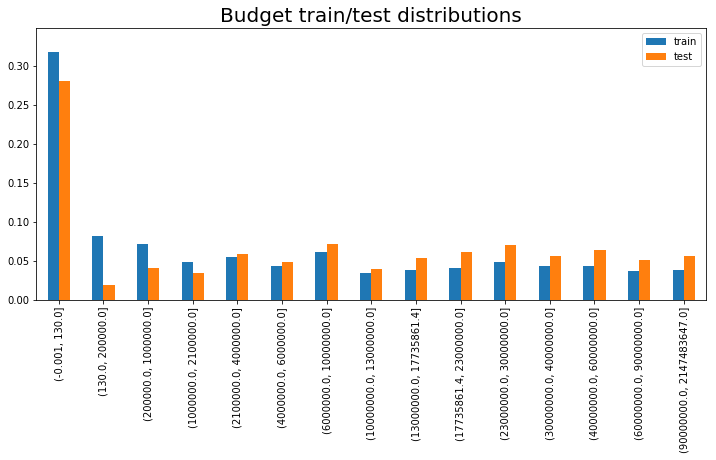

In [6]:
# comparing counts of each 5 percentiles
data['budget_cat'] = pd.cut(data['budget'], bins=data['budget'].quantile(np.arange(0, 1.01, 0.05)), duplicates='drop', include_lowest=True).astype(str)
compare_barplots_categorical(data[['budget_cat']], data['dataset']=='Train', data['dataset']=='Test', n_categories_in_figure=21, binned_categories=True)
plt.title('Budget train/test distributions', fontsize=20)

We can see that in the train set there tend to be more movies with lower budget. 

First, let's understand why there are so many low-budget movies in both train and test.

Text(0.5, 1.0, 'Fraction of low-budget movies')

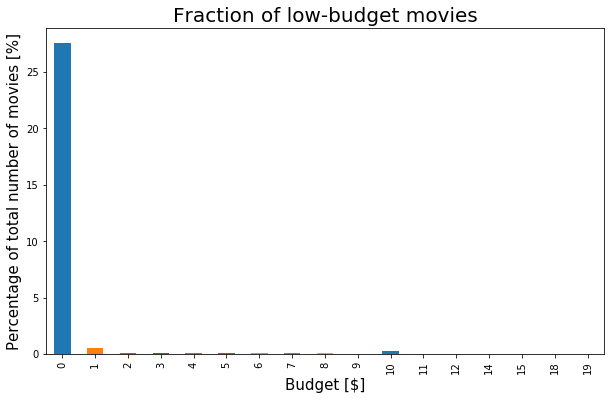

In [7]:
low_budget_value_counts = data.loc[data['budget'] <= 174, 'budget'].map(int).value_counts().sort_index()
series_cum_sum_percentages_low_budget = low_budget_value_counts.cumsum()/low_budget_value_counts.sum()
# let's convert to percentages of total
low_budget_value_counts = 100*low_budget_value_counts/len(data)
# let's leave budget categories responsible for 97% of low-budget bin
low_budget_value_counts = low_budget_value_counts[series_cum_sum_percentages_low_budget < 0.97]
low_budget_value_counts.plot.bar(figsize=(10,6))
plt.xlabel('Budget [$]', fontsize=15)
plt.ylabel('Percentage of total number of movies [%]', fontsize=15)
plt.title('Fraction of low-budget movies', fontsize=20)

In [8]:
%%HTML
<img src=https://i.imgflip.com/2wazn1.jpg width="250" align="left">

Do we really have more that 25% movies with no budget? 

In case there are indeed movies done without any budget at all, I'd expect them to have very low or no revenues. Let's check it.

Text(0.5, 1.0, 'Revenues of low-budget movies')

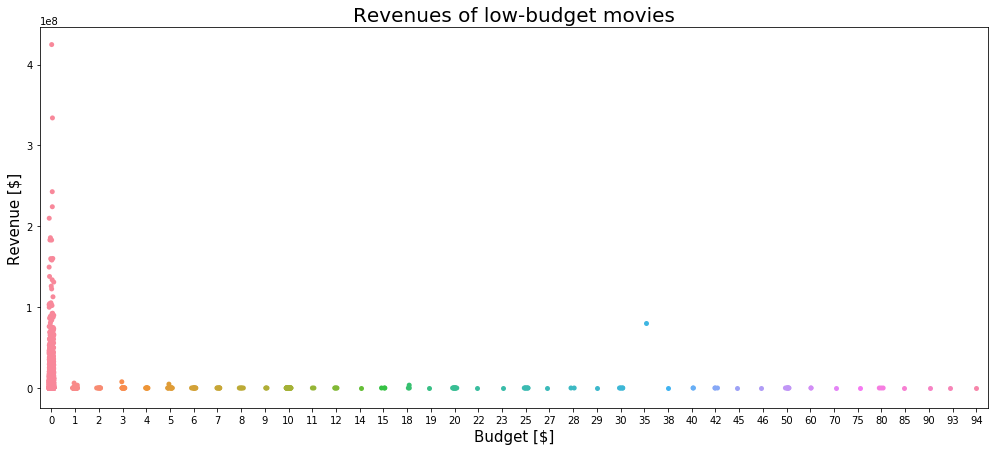

In [9]:
plt.figure(figsize=(17, 7))
logical_mask = data['budget'] < 100
sns.stripplot(x='budget', y='revenue', data=data[logical_mask], jitter=True)
plt.xlabel('Budget [$]', fontsize=15)
plt.ylabel('Revenue [$]', fontsize=15)
plt.title('Revenues of low-budget movies', fontsize=20)

Bingo. As billion-revenue movies are not made with zero budget, missing values in budget were obviously substituted with zeros.

In [10]:
%%HTML
<img src=https://memegenerator.net/img/instances/84246705/let-make-missing-values-nan-again.jpg width="300">

In [11]:
data.loc[data['budget'] == 0, 'budget'] = np.nan

Please note a movie with a budget of $35 and high revenue. Let's take a closer look.

In [12]:
data[(data['budget'] < 37) & (data['budget'] > 32)]

,Keywords,belongs_to_collection,budget,cast,crew,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,popularity2,poster_path,production_companies,production_countries,rating,release_date,revenue,runtime,spoken_languages,status,tagline,title,totalVotes,release_month,release_day,release_year,release_dayofweek,release_quarter,weightedRating,originalBudget,budget_adjusted,genders_0_crew,genders_1_crew,genders_2_crew,_collection_name,_num_Keywords,_num_cast,_popularity_mean_year,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,_popularity_totalVotes_ratio,_rating_popularity_ratio,_rating_totalVotes_ratio,_totalVotes_releaseYear_ratio,_budget_rating_ratio,_runtime_rating_ratio,_budget_totalVotes_ratio,has_homepage,isbelongs_to_collectionNA,isTaglineNA,isOriginalLanguageEng,isTitleDifferent,isMovieReleased,collection_id,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,production_countries_count,production_companies_count,cast_count,crew_count,runtime2meanRuntimeByYear,popularity2meanPopularityByYear,budget2meanBudgetByYear,totalVotes2meantotalVotesByYear,totalVotes2meanTotalVotesByRating,budget2medianBudgetByYear,dataset,budget_cat
4506,{},{},35.0,{},{},{},NaN,NaN,tt0281373,en,Snow Dogs,When a Miami dentist inherits a team of sled d...,7.698,NaN,NaN,{},{},5.4,2002-01-18,81000000.0,99.0,{},NaN,Get ready for mush hour!,Snow Dogs,337.0,18,1,2002,4.0,1.0,6.123261,35,48.853502,0,0,0,1,0,0,1.066991,0.353535,4.546635,0.000009,260.06755,0.003845,43.777605,0.701481,62.407407,0.168332,6.481481,18.333333,0.103858,0,0,0,1,0,0,NaN,9,2,2.0,25.0,5.0,0,0,0,0,0.937731,1.066991,0.000001,0.394028,0.801831,0.000003,Train,"(-0.001, 130.0]"


On the TMDB page of the movie we see that in fact the movies' budget was $35 000 000. It seems the Snow Dogs had enough money afterall :) 

In [13]:
%%HTML
<img src=https://image.tmdb.org/t/p/original/RdsII0tG6vdF6GTaiHePFaAKVM.jpg width="250">

Let's fix this record as well. 

Next, let's compare the resulted distributions.

Text(0.5, 1.0, 'Budget train/test distributions')

<Figure size 864x360 with 0 Axes>

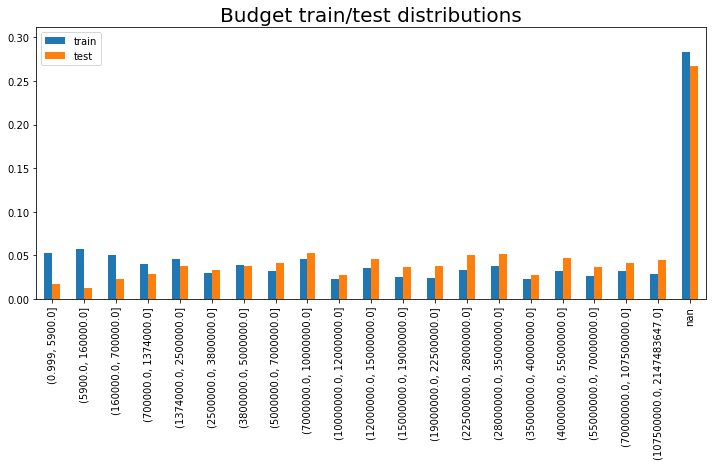

In [14]:
data.loc[data['budget'] == 35, 'budget'] *= 1e6
data['budget_cat'] = pd.cut(data['budget'], bins=data['budget'].quantile(np.arange(0, 1.01, 0.05)), duplicates='drop', include_lowest=True).astype(str)
compare_barplots_categorical(data[['budget_cat']], data['dataset']=='Train', data['dataset']=='Test', n_categories_in_figure=21, binned_categories=True)
plt.title('Budget train/test distributions', fontsize=20)

There are quite some missing budget entries. Let us check if the movies added by Kaggle community have budget records from TMDB.

In [15]:
data.loc[(data['release_year'] == 2018) & (data['budget'].isnull()), 'title'].head(20)

3003            They Shall Not Grow Old
3012                      The Favourite
3013                           Creed II
3015                         Green Book
3022                         Boy Erased
3029           Can You Ever Forgive Me?
3030                             Mid90s
3035                      Beautiful Boy
3036    Goosebumps 2: Haunted Halloween
3041         Bad Times at the El Royale
3046                           Suspiria
3047              The Old Man & the Gun
3050                           Wildlife
3051                        Life Itself
3055                             Lizzie
3056       Johnny English Strikes Again
3060                         Peppermint
3063                         Robin Hood
3064                                Kin
3065                   Operation Finale
Name: title, dtype: object

I checked that *Johnny English Strikes Again* has known budget on TMDB. Let us try filling missing budget entries by querying TMDB API.

In [16]:
data_enriched_path = '../input/tmdb-preprocessed/data_tmdb_enriched_with_popularities.h5'
# in order not to disclose my API key and to save some time I have uploaded the enriched dataset, 
# the dataset will be loaded after the final filling of values using the TMDB API
if not os.path.exists(data_enriched_path): 
    import tmdbsimple as tmdb
    tmdb.API_KEY = 'YOUR_KEY_HERE'
    search = tmdb.Search()
    hits_cout = 0
    missing_credits_mask = data['budget'].isnull()
    total_number_of_movies_to_fill = sum(missing_credits_mask)
    
    for index, movie_row in tqdm(data[missing_credits_mask].iterrows(), total=total_number_of_movies_to_fill):
        response = search.movie(query=movie_row['title']) if np.isnan(movie_row['release_year']) else search.movie(query=movie_row['title'], year=movie_row['release_year'])
        if response['total_results'] == 1:
            movie = tmdb.Movies(response['results'][0]['id'])
            movie_info = movie.info()
            if movie_info['budget'] != 0 and np.isnan(data.loc[index, 'budget']):
                hits_cout += 1
                data.loc[index, 'budget'] = movie_info['budget']
                
    # there were 202 filled entries
    
    # fixing features engineered based on budget
    data['budget_adjusted'] = (data['budget'].map(lambda x: [x]) + data['release_year'].map(lambda x: [x])).map(lambda budget_year: 
                                                                                                          cpi.inflate(budget_year[0], budget_year[1], to=2018)) #Inflation simple formula
    data['_budget_runtime_ratio'] = data['budget']/data['runtime'] 
    data['_budget_popularity_ratio'] = data['budget']/data['popularity']
    data['_budget_year_ratio'] = data['budget']/(data['release_year']*data['release_year'])
    data['_budget_rating_ratio'] = data['budget']/data['rating']
    data['_budget_totalVotes_ratio'] = data['budget']/data['totalVotes']    

Random check of movies with still missing budget confirmed that the budget was known neither on TMDB, nor on IMDB, nor on [www.the-numbers.com](www.the-numbers.com), nor on [kinopoisk](https://www.kinopoisk.ru).

Reasons:
"The info on movie budgets is even harder to find: studios are usually very reticent when it comes to discussing how much a film cost, especially when a movie performed poorly at the box-office. Additionally, reported budgets may change over time due to escalating costs (Waterworld and Titanic are two high profile examples) or costs may be difficult to calculate (the salary for a star or director may be part of a sum agreed for a package deal consisting of several films)." ([source IMDB page](https://help.imdb.com/article/imdb/discover-watch/why-are-your-budget-gross-figures-for-some-movies-different-than-those-listed-by-another-source/GCS37LSKVDMU37LV?ref_=helpart_nav_16#))

-------------------
Let's now get back to the observation that in the train set there tend to be more movies with lower budget. Let's check during which years the majority of lower-budget movies were created. 

Text(0.5, 1.0, 'Low-budget movies production')

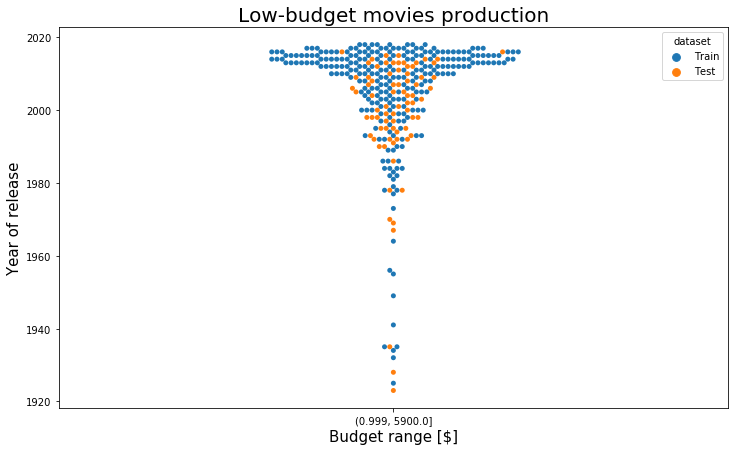

In [17]:
plt.figure(figsize=(12,7))
sns.swarmplot(x='budget_cat', y='release_year', data=data[data['budget'] < 6000], hue='dataset')
plt.xlabel('Budget range [$]', fontsize=15)
plt.ylabel('Year of release', fontsize=15)
plt.title('Low-budget movies production', fontsize=20)

Just as an interesting observation, the gathered dataset suggests that in the 2000s the film industry tend to produce more and more low/micro-budget movies. Let's hope it means that young filmmakers have more opportunities nowadays :) At the same time, it might be given by the fact that nowadays first-time filmmakers enter info about their work in databases like TMDB, while information about earlier low-budget movies might have been lost.

As in the 2000s the industry tends to produce more low-budget movies, the difference in budget distributions might be explained by the fact that in train set there are more years from the 2000s. To verify this,

Text(0.5, 1.0, 'Budget train/test distributions, initial dataset')

<Figure size 864x360 with 0 Axes>

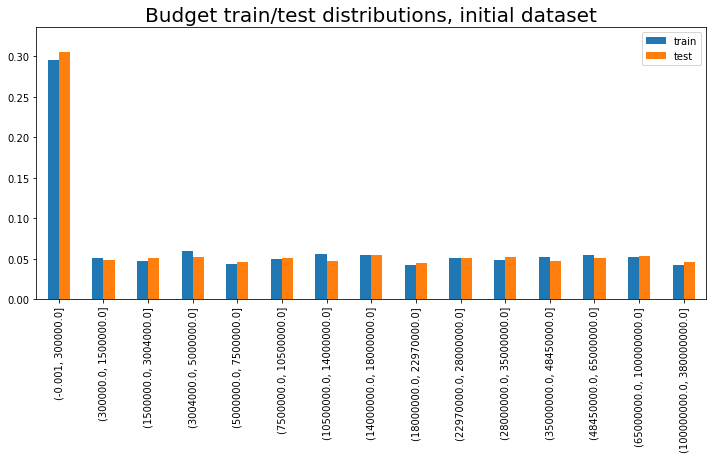

In [18]:
data_orig['budget_cat'] = pd.cut(data_orig['budget'], bins=data_orig['budget'].quantile(np.arange(0, 1.01, 0.05)), duplicates='drop', include_lowest=True).astype(str)
compare_barplots_categorical(data_orig[['budget_cat']], data_orig['dataset']=='Train', data_orig['dataset']=='Test', n_categories_in_figure=21, binned_categories=True)
plt.title('Budget train/test distributions, initial dataset', fontsize=20)

To conclude, initially there were no differences between train/test. The observed peculiarity in train vs. test comparison can be explained by additional data. We have also cleaned the data slightly. 

Finally, let us check if stratification by release year would lead to train/val split mimicking train/test split. 

Text(0.5, 1.0, 'Budget train/val distributions, stratified by release year')

<Figure size 864x360 with 0 Axes>

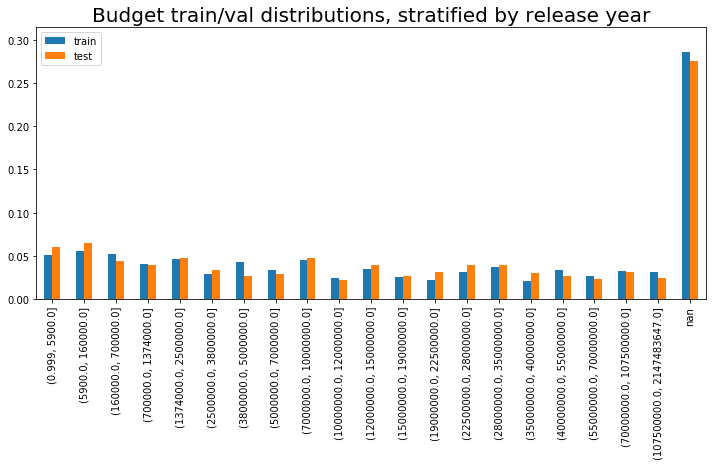

In [19]:
train_data = data[data['dataset'] == 'Train']
# let's merge early single-movie years into a joint release_year
yearly_movie_counts = train_data['release_year'].value_counts()
single_movie_years = set(yearly_movie_counts.index[yearly_movie_counts == 1])
train_data.loc[train_data['release_year'].isin(single_movie_years), 'release_year'] = 1
trn_indices_set, val_indices_set = [set(indices) for indices in train_test_split(train_data.index, stratify=train_data['release_year'])]
train_data.loc[train_data.index.isin(trn_indices_set), 'dataset'] = 'Train_train'
train_data.loc[train_data.index.isin(val_indices_set), 'dataset'] = 'Train_val'
compare_barplots_categorical(train_data[['budget_cat']], train_data['dataset'] == 'Train_train', train_data['dataset'] == 'Train_val', 
                             n_categories_in_figure=21, binned_categories=True)
plt.title('Budget train/val distributions, stratified by release year', fontsize=20)

It increases confidence with stratification by release year. Let us analogously check other attributes to validate the release-year stratification.

### Train vs. test rating distribution
Analogously to budget check, let us now check rating and see if stratification by the year would lead to the same rating distributions compared to train vs. test pair. Along the way, let us again explore anything interesting we notice (such attitude helped us to clean data already).

In [20]:
def nans_proportion(pd_series, logical_index=None):
    if logical_index is None:
        logical_index = np.ones_like(pd_series, dtype=np.bool)
    return pd_series[logical_index].isnull().sum()/logical_index.sum()
print(f"In train proportion of missing values is: {100*nans_proportion(data['rating'], data['dataset']=='Train'):.2f} %.")
print(f"In test proportion of missing values is: {100*nans_proportion(data['rating'], data['dataset']=='Test'):.2f} %.")

In train proportion of missing values is: 2.36 %.
In test proportion of missing values is: 4.07 %.


Text(0.5, 1.0, 'Rating train/test distributions')

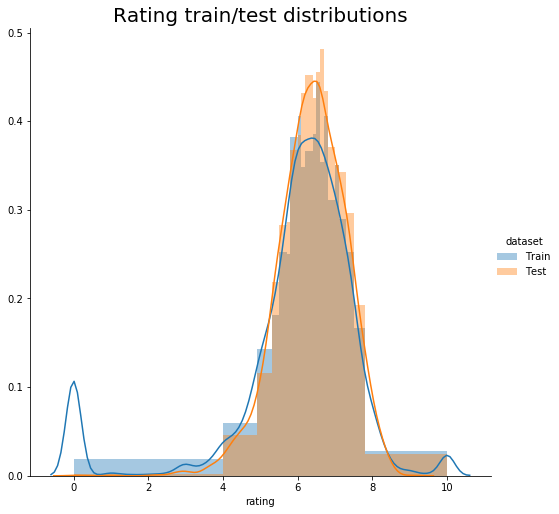

In [21]:
bins = data['rating'].quantile(np.arange(0, 1.001, 0.05))
g = sns.FacetGrid(data, hue='dataset', height=7)
g = g.map(sns.distplot, 'rating', bins=bins)
g.add_legend()
plt.title('Rating train/test distributions', fontsize=20)

There is an apparent difference in the distributions for very small and very large ratings. Let's check years of release for the low-rating movies (as it corresponds to a significantly higher mode of the distribution).

Text(0.5, 1.0, 'Low-rating movies production')

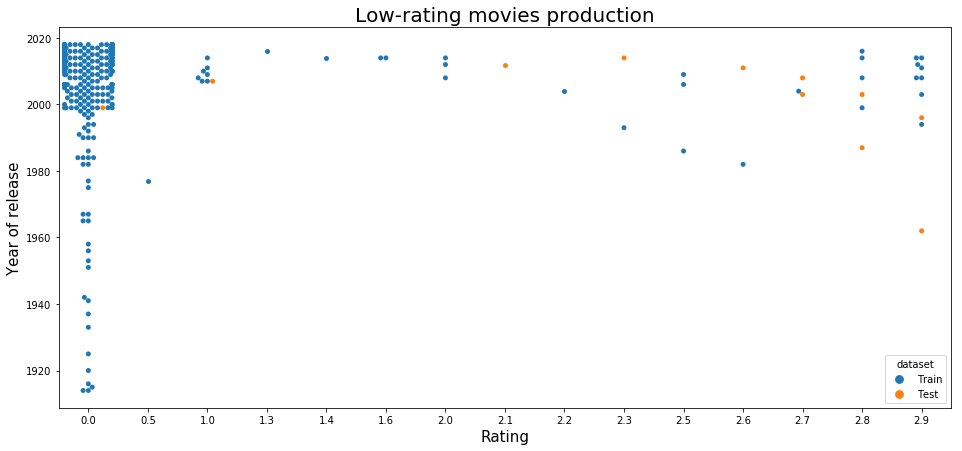

In [22]:
plt.figure(figsize=(16,7))
sns.swarmplot(x='rating', y='release_year', data=data[data['rating'] < 3], hue='dataset')
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Year of release', fontsize=15)
plt.title('Low-rating movies production', fontsize=20)

Does the film industry produce more and more movies in 2000s and as the consequence there are also more low-rating movies recently? Or does the proportion of low-rating movies tend to increase? Let us quickly check how the proportion of low-ranking movies changed over recent years.

Text(0.5, 1.0, 'Low-rating movies proportion')

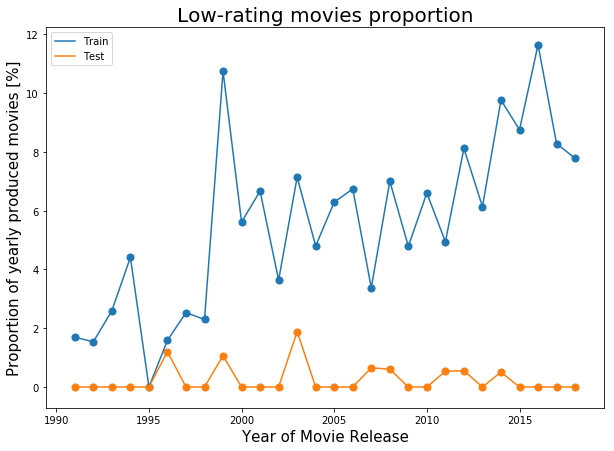

In [23]:
low_rating_proportion_trn = 100 * data[(data['release_year'] > 1990) & (data['dataset'] == 'Train')].groupby('release_year')['rating'].agg(lambda x: sum(x < 3)/len(x))
low_rating_proportion_tst = 100 * data[(data['release_year'] > 1990) & (data['dataset'] == 'Test')].groupby('release_year')['rating'].agg(lambda x: sum(x < 3)/len(x))

def plot_with_dots(ax, series):
    ax.scatter(series.index, series, s=50)
    ax.plot(series.index, series)

plt.figure(figsize=(10,7))
plot_with_dots(plt, low_rating_proportion_trn)
plot_with_dots(plt, low_rating_proportion_tst)

plt.xlabel('Year of Movie Release', fontsize=15)
plt.ylabel('Proportion of yearly produced movies [%]', fontsize=15)
plt.legend(['Train', 'Test'])
plt.title('Low-rating movies proportion', fontsize=20)

We can see that there are almost no low-ranking movies in the test set. Is it true just for the test set or for the whole initial dataset?

Text(0.5, 1.0, 'Low-rating movies proportion')

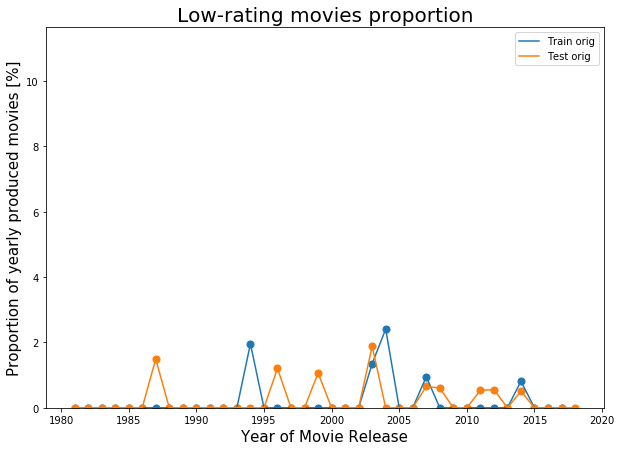

In [24]:
data_orig = data_orig.merge(data[['id', 'rating']], on='id', how='left')
low_rating_proportion_trn_orig = 100 * data_orig[(data_orig['release_year'] > 1980) &
                                                 (data_orig['dataset'] == 'Train')
                                                ].groupby('release_year')['rating'].agg(lambda x: sum(x < 3)/len(x))
low_rating_proportion_tst_orig = 100 * data_orig[(data_orig['release_year'] > 1980) &
                                                 (data_orig['dataset'] == 'Test')
                                                ].groupby('release_year')['rating'].agg(lambda x: sum(x < 3)/len(x))

plt.figure(figsize=(10,7))
plot_with_dots(plt, low_rating_proportion_trn_orig)
plot_with_dots(plt, low_rating_proportion_tst_orig)

plt.xlabel('Year of Movie Release', fontsize=15)
plt.ylabel('Proportion of yearly produced movies [%]', fontsize=15)
plt.legend(['Train orig', 'Test orig'])
plt.ylim(0, low_rating_proportion_trn.max())
plt.title('Low-rating movies proportion', fontsize=20)

So, in the initial dataset there were almost no low-ranking movies. Let's see some low-ranking movies which were added (to verify that they indeed have such a low ranking).

In [25]:
# in the year 1990 there were no low-ranking movies in the initial dataset, if we check the figure above. So these movies were definitely added
data.loc[(data['dataset'] == 'Train') & (data['release_year'] == 1990) & (data['rating'] < 3), ['title', 'imdb_id']]

,title,imdb_id
4742,Dozde aroosak-ha,tt0123046
4743,Safare Jadooei,tt0254744
4744,Safare Jadooei,tt0254744


We have discovered that there are duplicates in the used dataset, likely due to the additionally added movies in the previously published kernels. Let us clean it up.

In [26]:
print(f"Number of duplicated movies: {len(data) - data['imdb_id'].isnull().sum() - data['imdb_id'].nunique()}.")
data = data.iloc[data.astype(str).drop_duplicates().index]
print(f"After the cleaning, number of duplicated movies: {len(data) - data['imdb_id'].isnull().sum() - data['imdb_id'].nunique()}.")

Number of duplicated movies: 32.
After the cleaning, number of duplicated movies: 0.


Let us get back to the low-rating movies which were added. 

We can see from the figures above that in the initial train data there were no movies having ranking under 3 and released in 1999. Yet, in the final train data more than 10% of all movies have ranking this low. Let us now use year 1999 to check if the movies are indeed low-ranked.

In [27]:
data.loc[(data['dataset'] == 'Train') & (data['release_year'] == 1999) & (data['rating'] < 3), 'title'].iloc[:5]

4567              Sheyda
4568          Aadhi Raat
4569    Khoonkar Darinde
4570     Shaitan Tantrik
4573      Sar Kati Laash
Name: title, dtype: object

This checks out: the movies have rating 0 on TMDB. 

To sum up, the initial training data seemed to ignore significant number of B-movies. But there are quite some B-movies recently, if we look at their proportion out of the total count.

Text(0.5, 1.0, 'Low-rating movies proportion')

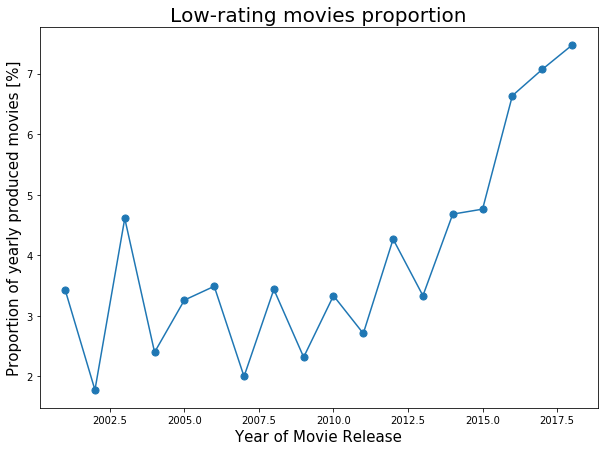

In [28]:
low_rating_proportion = 100 * data[data['release_year'] > 2000].groupby('release_year')['rating'].agg(lambda x: sum(x < 3)/len(x))

plt.figure(figsize=(10,7))
plot_with_dots(plt, low_rating_proportion)

plt.xlabel('Year of Movie Release', fontsize=15)
plt.ylabel('Proportion of yearly produced movies [%]', fontsize=15)
plt.title('Low-rating movies proportion', fontsize=20)

It seems like an opportunity for an extrapolation joke!
![](https://imgs.xkcd.com/comics/extrapolating.png)

Text(0.5, 0.98, 'Low-rating movies proportion')

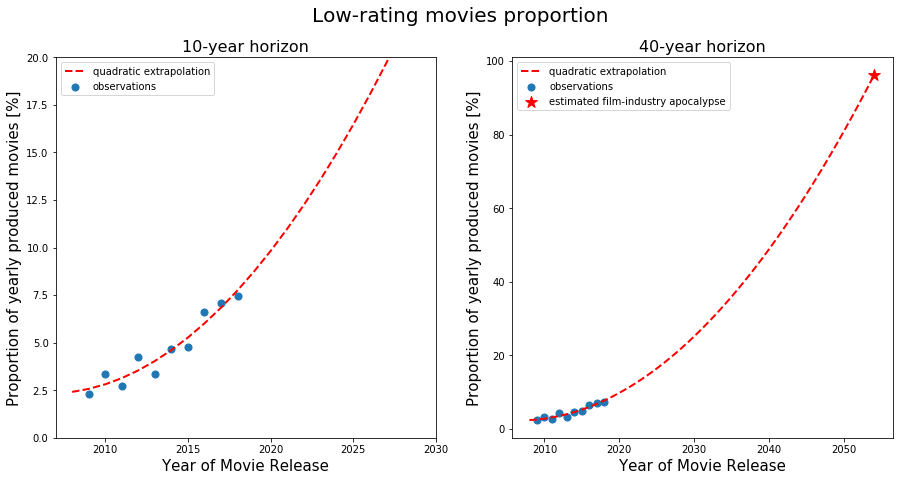

In [29]:
low_rating_proportion_latest = data[data['release_year'] > 2008].groupby('release_year', as_index=False)['rating'].agg(lambda x: 100*sum(x < 3)/len(x))
low_rating_proportion_latest.columns = ['release_year', 'low_ranking_proportion']
coeffs = np.polyfit(low_rating_proportion_latest['release_year'], low_rating_proportion_latest['low_ranking_proportion'], deg=2)
apocalypse_year = int(np.ceil(np.max(np.roots(np.concatenate((coeffs[:-1], coeffs[-1:] - 100))))))
extrapolation = [np.polyval(coeffs, year) for year in range(2008, apocalypse_year)]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.plot(list(range(2008, apocalypse_year)), extrapolation, '--', linewidth=2, c='r')
ax1.scatter(low_rating_proportion_latest['release_year'], low_rating_proportion_latest['low_ranking_proportion'], s=50)
ax1.set_xlabel('Year of Movie Release', fontsize=15)
ax1.set_ylabel('Proportion of yearly produced movies [%]', fontsize=15)
ax1.set_ylim(0, 20)
ax1.set_xlim(2007, 2030)
ax1.legend(['quadratic extrapolation', 'observations'])
ax1.set_title('10-year horizon', fontsize=16)


ax2.scatter(low_rating_proportion_latest['release_year'], low_rating_proportion_latest['low_ranking_proportion'], s=50)
ax2.scatter([apocalypse_year - 1], extrapolation[-1], s=150, c='r', marker='*')
ax2.plot(list(range(2008, apocalypse_year)), extrapolation, '--', linewidth=2, c='r')
ax2.set_xlabel('Year of Movie Release', fontsize=15)
ax2.set_ylabel('Proportion of yearly produced movies [%]', fontsize=15)
ax2.legend(['quadratic extrapolation', 'observations', 'estimated film-industry apocalypse'])
ax2.set_title('40-year horizon', fontsize=16)
plt.suptitle('Low-rating movies proportion', fontsize=20)

If we don't do anything about it now, then by year 2030 more than one fifth of all movies might be B-movies and by year 2060 we might end up with B-movies only. The apocalypse of the film-industry we love! ;)

Speaking seriously, let us check how many movies with good ranking were produced in recent years.

Text(0.5, 1.0, 'Movies with ranking >= 8')

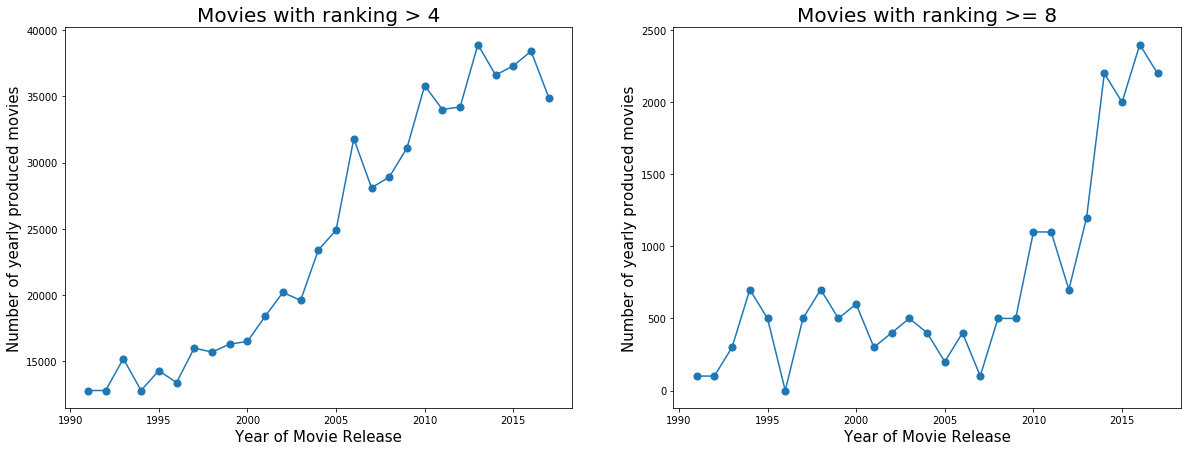

In [30]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

adequate_rating_count = 100 * data[(data['release_year'] > 1990) & (data['release_year'] < 2018)].groupby('release_year')['rating'].agg(lambda x: sum(x > 4))

plot_with_dots(ax1, adequate_rating_count)
ax1.set_xlabel('Year of Movie Release', fontsize=15)
ax1.set_ylabel('Number of yearly produced movies', fontsize=15)
ax1.set_title('Movies with ranking > 4', fontsize=20)

great_rating_count = 100 * data[(data['release_year'] > 1990) & (data['release_year'] < 2018)].groupby('release_year')['rating'].agg(lambda x: sum(x >= 8))

plot_with_dots(ax2, great_rating_count)
ax2.set_xlabel('Year of Movie Release', fontsize=15)
ax2.set_ylabel('Number of yearly produced movies', fontsize=15)
ax2.set_title('Movies with ranking >= 8', fontsize=20)

So, we can see that the film industry also produces more and more movies with good rankings.

Thanks to my brother’s advice, I scanned through [introduction to David Hesmondhalgh's book "The Cultural Industries"](https://www.researchgate.net/publication/261554803_The_Cultural_Industries_3rd_Ed). It cites the study by Bettig from 1996 showing that less than 3% of released movies are going to become box office hits. As a result, Hesmondhalgh argures that *"in the cultural industries, companies tend to offset misses against hits by means of ‘overproduction’ (Hirsch, 1990), attempting to put together a large catalogue or ‘cultural repertoire’ (Garnham, 1990) or, to put it another way, ‘throwing mud’ – or other similar substances – ‘against the wall’ to see what sticks (Laing, 1985: 9; Negus, 1999: 34)."*

These tendencies might explain what we observe: the companies tend to produce more and more movies betting on success of just a few hits which should cover all the costs. Good news is that in the figure above we indeed see more and more successful movies with good rankings. Yet, as we've seen and as Hesmondhalgh argues, to get there, companies might need to produce more and more not so successful movies.

To sum up, I believe we should not be afraid of the film-industry apocalypse "estimated" before, and future generations would hopefully have enough great movies :)

______________
*Please note that I tried to remove the ranking outlier movies as well as to hide zeros and tens under NaNs. Neither improved the score. In our case having more data seem to help the model even if those additional data have distributions of parameters slightly away from the corresponding test distributions. Yet, dealing with the outliers might require more thorough investigation, I performed just a very quick check.*

Now, let us check that train/val split stratified by release year lead to similar distributions of rating.

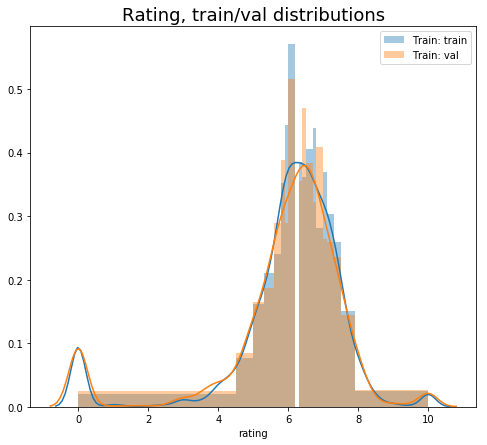

In [31]:
train_data = data[data['dataset'] == 'Train']
# let's merge early single-movie years into a joint release_year
yearly_movie_counts = train_data['release_year'].value_counts()
single_movie_years = set(yearly_movie_counts.index[yearly_movie_counts == 1])
train_data.loc[train_data['release_year'].isin(single_movie_years), 'release_year'] = 1
trn_indices_set, val_indices_set = [set(indices) for indices in train_test_split(train_data.index, stratify=train_data['release_year'])]
train_data.loc[train_data.index.isin(trn_indices_set), 'dataset'] = 'Train_train'
train_data.loc[train_data.index.isin(val_indices_set), 'dataset'] = 'Train_val'

plt.figure(figsize=(8, 7))
bins = train_data['rating'].quantile(np.arange(0, 1.001, 0.05))
sns.distplot(train_data.loc[train_data['dataset'] == 'Train_train', 'rating'], bins=bins)
sns.distplot(train_data.loc[train_data['dataset'] == 'Train_val', 'rating'], bins=bins)
plt.title('Rating, train/val distributions', fontsize=18)
plt.legend(['Train: train', 'Train: val'])

Gaining more and more confidence in stratification by release year.

### Adversarial validation

We saw that some interesting aspects of our training data (such as zero and max-rating outliers) are not present in test data. In order to discover other potential peculiarities of our train data, let us perform adversarial validation and focus on features which discriminate train vs. test.

In [32]:
importances = pd.DataFrame()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
# we already checked budget and ranking, so we omit those as well
data_adversarial_validation = data.drop(['Keywords', 'belongs_to_collection', 'homepage', 'budget_cat', 'cast', 'crew', 
                                         'genres', 'imdb_id', 'id', 'original_title', 'overview', 'poster_path', 
                                         'production_companies', 'production_countries', 'spoken_languages', 
                                         'tagline', 'title', 'original_language', 'release_date', 'status', 'revenue'] +
                                        [col for col in data.columns if 'rating' in col.lower() or 'budget' in col.lower()], axis=1)

dataset_year = data_adversarial_validation['dataset'].map(str) + '_' + data_adversarial_validation['release_year'].map(str)
data_adversarial_validation['dataset'] = data_adversarial_validation['dataset'].map(lambda x: 1 if x == 'Test' else 0)

auc_mean = 0
for fold_idx, (trn_idx, val_idx) in enumerate(skf.split(dataset_year, dataset_year)):

    df_trn = data_adversarial_validation.iloc[trn_idx]
    trn_y = df_trn['dataset']
    df_trn.drop(['dataset'], axis=1, inplace=True)
    df_val = data_adversarial_validation.iloc[val_idx]
    val_y = df_val['dataset']
    df_val.drop(['dataset'], axis=1, inplace=True)

    clf = LGBMClassifier(objective='binary',
                         boosting_type='gbdt',
                         n_jobs=-1,
                         n_estimators=2000,
                         metric='auc')

    clf.fit(
        df_trn, trn_y,
        eval_set=[(df_trn, trn_y), (df_val, val_y)],
        early_stopping_rounds=50,
        verbose=0
    )
    auc_mean += roc_auc_score(val_y, clf.predict_proba(df_val)[:, 1])/skf.get_n_splits()
    imp_df = pd.DataFrame({
                'feature': df_trn.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_idx + 1] * len(df_trn.columns),
                })
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
print(f'Mean AUC: {auc_mean:.3}.')

Mean AUC: 0.707.


<BarContainer object of 39 artists>

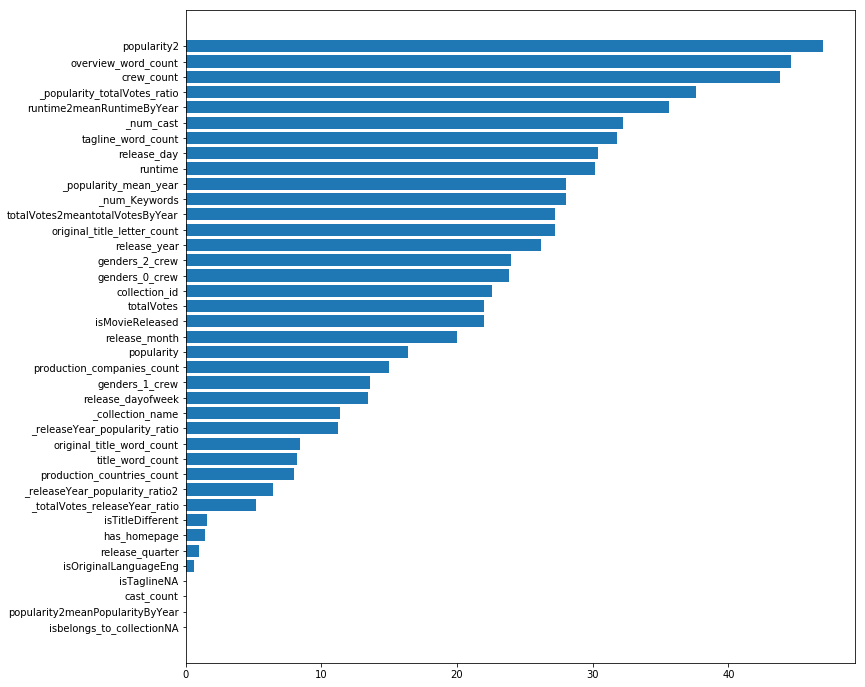

In [33]:
plt.figure(figsize=(12,12))
mean_importances = importances.groupby('feature')['gain'].mean().sort_values()
plt.barh(y=mean_importances.index, width=mean_importances)

#### Popularity2

In [34]:
print(f"In train proportion of missing values is: {100*nans_proportion(data['popularity2'], data['dataset']=='Train'):.2f} %.")
print(f"In test proportion of missing values is: {100*nans_proportion(data['popularity2'], data['dataset']=='Test'):.2f} %.")

In train proportion of missing values is: 41.92 %.
In test proportion of missing values is: 4.07 %.


In [35]:
print(f"""In additional train data from 2018, 
proportion of missing values is: {100*nans_proportion(data['popularity2'], (data['dataset']=='Train') & (data['release_year']==2018)):.2f} %.""")

In additional train data from 2018, 
proportion of missing values is: 100.00 %.


Text(0.5, 1.0, 'Popularity2 train/test distributions')

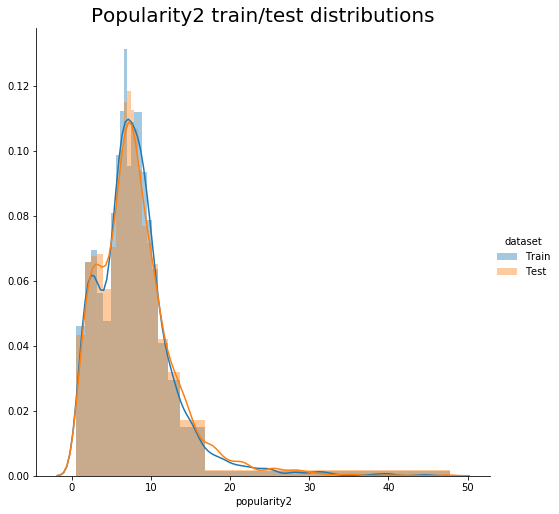

In [36]:
bins = data['popularity2'].quantile(np.arange(0, 1.001, 0.05))
g = sns.FacetGrid(data, hue='dataset', height=7)
g = g.map(sns.distplot, 'popularity2', bins=bins)
g.add_legend()
plt.title('Popularity2 train/test distributions', fontsize=20)

We can see just the slight difference around the lower mode of distribution. The main issue is that the movies added to train additionally seemingly don't contain ```popularity2```.

I tried to understand what popularity represents and why there are two columns. When I queried TMDB API, I got the third value which equals neither to ```popularity```, nor to ```popularity2```. It turned out that the popularity is "*really only used for boosting search results and trending results over time*"([source](https://www.themoviedb.org/talk/5a42cf99c3a368586c04177a)). Based on [the documentation](https://developers.themoviedb.org/3/getting-started/popularity) we can further confirm that the ```popularity``` is about recent activity on the movie's TMDB webpage. It might be interesting to know web activity just before the movie release. Yet, it turned out that the webpage popularity is helpful for the prediction. Let us get the most recent popularity us TMDB API. 

In [37]:
if not os.path.exists(data_enriched_path): 
    import tmdbsimple as tmdb
    tmdb.API_KEY = 'YOUR_KEY'
    search = tmdb.Search()
    hits_cout = 0
    data['popularity3'] = np.nan
    total_number_of_movies_to_fill = len(data)
    
    for index, movie_row in tqdm(data.iterrows(), total=total_number_of_movies_to_fill):
        response = search.movie(query=movie_row['title']) if np.isnan(movie_row['release_year']) else search.movie(query=movie_row['title'], year=movie_row['release_year'])
        if response['total_results'] == 1:
            movie = tmdb.Movies(response['results'][0]['id'])
            movie_info = movie.info()
            data.loc[index, 'popularity3'] = movie_info['popularity']
    helping_series = data['popularity'].map(lambda x: [x]) + data['popularity2'].map(lambda x: [x]) + data['popularity3'].map(lambda x: [x])
    data['popularity_mean'] = helping_series.map(np.nanmean)

#### Overviews

In [38]:
print(f"From the most recent added movies {100 * nans_proportion(data['overview'], data['release_date'] > latest_release_date_test):.1f} % do not have overview.")
print(f"In the original dataset {100 * nans_proportion(data_orig['overview']):.1f} % of movies do not have overview")

From the most recent added movies 2.5 % do not have overview.
In the original dataset 0.3 % of movies do not have overview


Text(0.5, 0.98, 'Overview_word_count distributions')

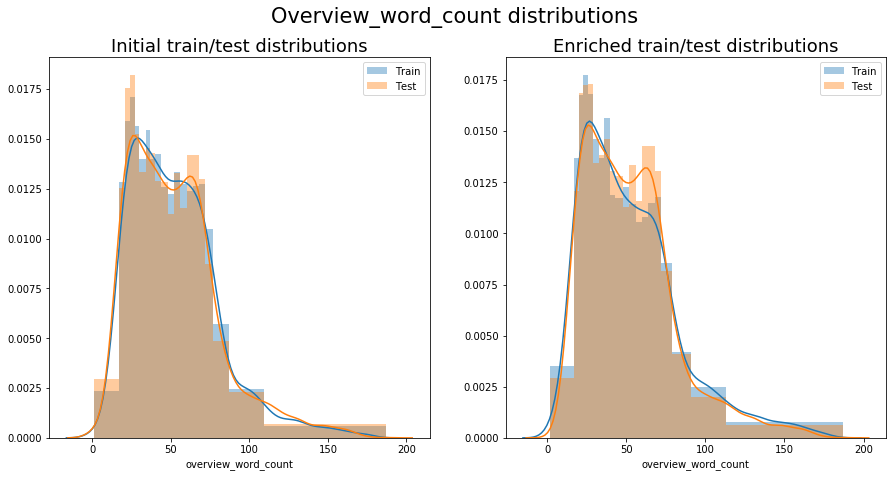

In [39]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
data_orig['overview_word_count'] = data_orig['overview'].map(lambda x: len(str(x).split()))
bins = data_orig['overview_word_count'].quantile(np.arange(0, 1.001, 0.05))
sns.distplot(data_orig.loc[data_orig['dataset'] == 'Train', 'overview_word_count'], bins=bins, ax=ax1)
sns.distplot(data_orig.loc[data_orig['dataset'] == 'Test', 'overview_word_count'], bins=bins, ax=ax1)
ax1.set_title('Initial train/test distributions', fontsize=18)
ax1.legend(['Train', 'Test'])


bins = data['overview_word_count'].quantile(np.arange(0, 1.001, 0.05))
sns.distplot(data.loc[data['dataset'] == 'Train', 'overview_word_count'], bins=bins, ax=ax2)
sns.distplot(data.loc[data['dataset'] == 'Test', 'overview_word_count'], bins=bins, ax=ax2)
ax2.set_title('Enriched train/test distributions', fontsize=18)
ax2.legend(['Train', 'Test'])
plt.suptitle('Overview_word_count distributions', fontsize=21)

Interestingly, in the added movies there are more short overviews. 

Text(0.5, 1.0, 'Overview length, last three decades')

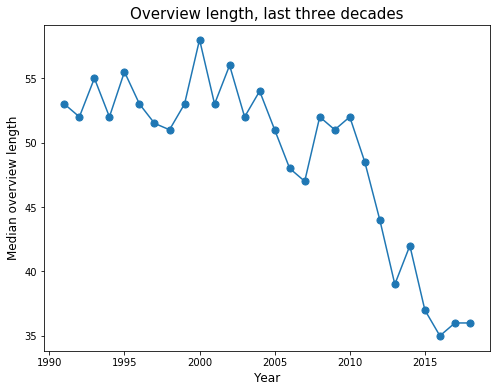

In [40]:
plt.figure(figsize=(8,6))
plot_with_dots(plt, data[data['release_year'] > 1990].groupby('release_year')['overview_word_count'].median())
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median overview length', fontsize=12)
plt.title('Overview length, last three decades', fontsize=15)

The train vs. test difference seems to be given by recent trends in overview style and the fact that there are more recent movies in train data. Out of curiosity, let us check some consice overviews.

In [41]:
pd.set_option('display.max_colwidth', -1)
data.loc[(data['release_year'] > 2015) & (data['overview_word_count'] < 20), ['title', 'overview']].sample(5, random_state=2)

,title,overview
3515,A Fantastic Woman,A waitress and singer struggles to recover from the death of her boyfriend.
6652,Despicable Me 3,Gru and his wife Lucy must stop former '80s child star Balthazar Bratt from achieving world domination.
458,My Big Fat Greek Wedding 2,"The continuing adventures of the Portokalos family. A follow-up to the 2002 comedy, ""My Big Fat Greek Wedding."""
3163,A Quiet Place,A family is forced to live in silence while hiding from creatures that hunt by sound.
8129,One Piece Film: GOLD,"The Straw Hat Pirates are taking on Gild Tesoro, one of the richest men in the world."


#### Tagline/Cast
Let's check why tagline and cast count helps distunguish between train and test.

In [42]:
print(f"From originally available movies {100 * nans_proportion(data_orig['tagline']):.1f} % do not have a tagline.")
print(f"From the most recent added movies {100 * nans_proportion(data['tagline'], data['release_date'] > latest_release_date_test):.1f} % do not have a tagline.")

From originally available movies 19.7 % do not have a tagline.
From the most recent added movies 39.4 % do not have a tagline.


Text(0.5, 1.0, 'Tagline length, last three decades')

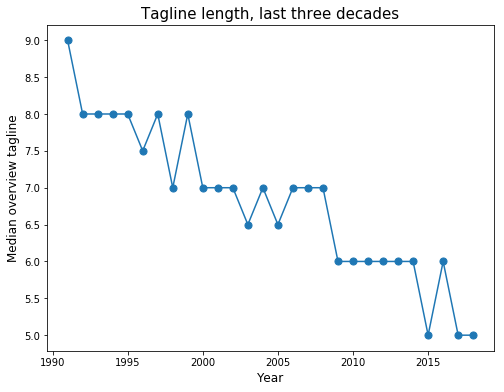

In [43]:
plt.figure(figsize=(8,6))
plot_with_dots(plt, data[data['release_year'] > 1990].groupby('release_year')['tagline_word_count'].median())
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median overview tagline', fontsize=12)
plt.title('Tagline length, last three decades', fontsize=15)

Again, we observe analogous trend to the one in overview length. Seemingly, we tend to write shorter. Hopefully, it's the sign that we as the humanity are evolving. Let's stay optimistic.

In [44]:
%%HTML
<img src=http://wist.info/wp/wp-content/uploads/2016/04/Chekhov-brevity-sister-of-talent-wist_info-quote.jpg width='400'>

Let us now check cast counts.

In [45]:
print(f"From originally available movies {100 * nans_proportion(data_orig['crew']):.1f} % do not have information about crew.")
fraction_of_record_with_missing_crew = data.loc[data['release_date'] > latest_release_date_test, 'crew'].map(lambda x: len(x) == 0).sum()/sum(data['release_date'] > latest_release_date_test)
print(f'From the most recent added movies {100 * fraction_of_record_with_missing_crew:.1f} % do not have information about crew.')

From originally available movies 0.5 % do not have information about crew.
From the most recent added movies 98.2 % do not have information about crew.


Let's try to fill in the missing values by querying TMDB.

#### Filling in missing values using TMDB API
In order not to disclose my API key and to save some time, I have uploaded the enriched dataset

In [46]:
if os.path.exists(data_enriched_path):
    data = pd.read_hdf(data_enriched_path, 'data')
else:
    import tmdbsimple as tmdb
    tmdb.API_KEY = 'YOUR_KEY_HERE'
    search = tmdb.Search()
    hits_cout = 0
    attributes_to_fill = ['crew', 'cast', 'Keywords', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
    missing_credits_mask = (data[attributes_to_fill[0]].map(lambda x: len(x) == 0))
    for col in attributes_to_fill[1:]:
        missing_credits_mask = missing_credits_mask | (data[col].map(lambda x: len(x) == 0))
    total_number_of_movies_to_fill = sum(missing_credits_mask)
    # substituting dummy empty dicts with lists
    for col in attributes_to_fill:
        data.loc[missing_credits_mask, col] = data.loc[missing_credits_mask, col].map(lambda x: [] if isinstance(x, dict) else x)
    for index, movie_row in tqdm(data[missing_credits_mask].iterrows(), total=total_number_of_movies_to_fill):
        response = search.movie(query=movie_row['title']) if np.isnan(movie_row['release_year']) else search.movie(query=movie_row['title'], year=movie_row['release_year'])
        if response['total_results'] == 1:
            movie = tmdb.Movies(response['results'][0]['id'])
            movie_info = movie.info(append_to_response='credits,keywords')
            if len(data.loc[index, 'cast']) == 0:
                data.loc[index, 'cast'].extend(movie_info['credits']['cast'])
            if len(data.loc[index, 'crew']) == 0:
                data.loc[index, 'crew'].extend(movie_info['credits']['crew'])
            if len(data.loc[index, 'Keywords']) == 0:
                data.loc[index, 'Keywords'].extend(movie_info['keywords']['keywords'])
            for col in attributes_to_fill[3:]:
                if len(data.loc[index, col]) == 0:
                    data.loc[index, col].extend(movie_info[col])
            hits_cout += int(len(movie_info['credits']['cast']) > 0 or len(movie_info['credits']['crew']) > 0)

    print(f'Filling in was successful for {hits_cout} movies out of {total_number_of_movies_to_fill}.')
    data.to_hdf(data_enriched_path, 'data')

We have imputed quite some missing values, let's redo feature engineering from the previously available kernels if it was based on the imputed features.

In [47]:
from sklearn.preprocessing import LabelEncoder
# Thanks to this Kernel for the next 7 features https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
data['genders_0_crew'] = data['crew'].apply(lambda x: sum([i['gender'] == 0 for i in x]) if isinstance(x, list) else np.nan)
data['genders_1_crew'] = data['crew'].apply(lambda x: sum([i['gender'] == 1 for i in x]) if isinstance(x, list) else np.nan)
data['genders_2_crew'] = data['crew'].apply(lambda x: sum([i['gender'] == 2 for i in x]) if isinstance(x, list) else np.nan)
data['_collection_name'] = data['belongs_to_collection'].apply(lambda x: x[0]['name'] if isinstance(x, list) else np.nan)
le = LabelEncoder()
data['_collection_name'] = le.fit_transform(data['_collection_name'].map(str))
data.loc[data['_collection_name'].map(str) == 'nan', '_collection_name'] = np.nan
data['_num_Keywords'] = data['Keywords'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
data['_num_cast'] = data['cast'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

#thanks to the cited Kamal's kernel
data['production_countries_count'] = data['production_countries'].apply(lambda x : len(x) if isinstance(x, list) else np.nan)
data['production_companies_count'] = data['production_companies'].apply(lambda x : len(x) if isinstance(x, list) else np.nan)
data['cast_count'] = data['cast'].apply(lambda x : len(x) if isinstance(x, list) else np.nan)
data['crew_count'] = data['crew'].apply(lambda x : len(x) if isinstance(x, list) else np.nan)

## Feature engineering

### Revenue and inflation
Let us compare trend in movie revenues over years with a trend in inflation. For inflation adjustment we are going to use Consumer Price Index and [this library](https://github.com/datadesk/cpi). 

Text(0.5, 1.0, 'Investigating effects of inflation')

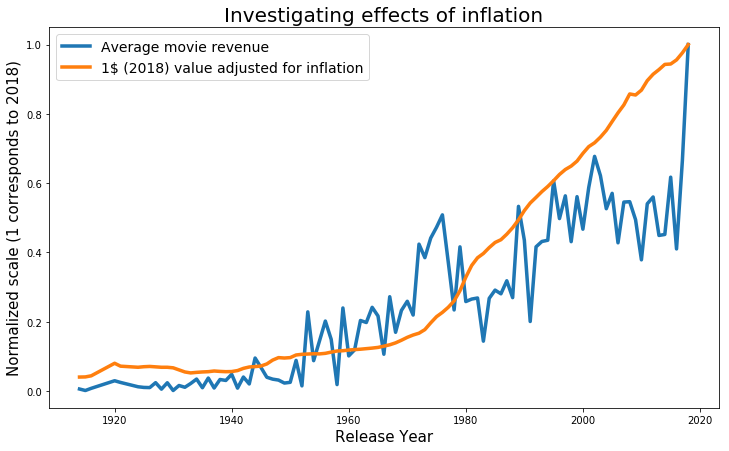

In [48]:
mean_yearly_revenues = train.groupby('release_year', as_index=False)['revenue'].agg(np.nanmean)
mean_yearly_revenues['revenue'] /= mean_yearly_revenues.iloc[-1]['revenue']
# let's see what one 2018 dollar cost was throught the history of cinema
cpi_2018 = cpi.get(year_or_month=2018)
dollar_costs = [cpi.get(year_or_month=year)/cpi_2018 for year in mean_yearly_revenues['release_year'].values]
plt.figure(figsize=(12, 7))
plt.plot(mean_yearly_revenues['release_year'], mean_yearly_revenues['revenue'], linewidth=3.5)
plt.plot(mean_yearly_revenues['release_year'], dollar_costs, linewidth=3.5)
plt.legend(['Average movie revenue', '1$ (2018) value adjusted for inflation'], fontsize=14)
plt.xlabel('Release Year', fontsize=15)
plt.ylabel('Normalized scale (1 corresponds to 2018)', fontsize=15)
plt.title('Investigating effects of inflation', fontsize=20)

Observations:
1. If we would like to see which decade was the best for the film industry, then we must adjust revenues for inflation.
2. In 2018 there is a jump in mean revenue.

Let us add information about inflation to the dataset.

In [49]:
dollar_costs_df = pd.DataFrame({'year': mean_yearly_revenues['release_year'], 'dollar_2018_cost': dollar_costs})
data['dollar_2018_cost'] = data[['release_year']].merge(dollar_costs_df, left_on='release_year', right_on='year')['dollar_2018_cost']

#### Quick check of 2018 data

Text(0, 0.5, 'Revenue')

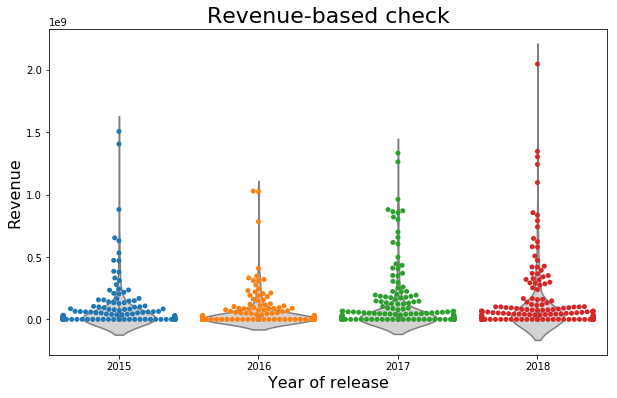

In [50]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='release_year', y='revenue', data=train[train['release_date'] >= '2015-01-01'], color='lightgray')
sns.swarmplot(x='release_year', y='revenue', data=train[train['release_date'] >= '2015-01-01'])
plt.title('Revenue-based check', fontsize=22)
plt.xlabel('Year of release', fontsize=16)
plt.ylabel('Revenue', fontsize=16)

There is some high-revenue outlier released in 2018. Let's check the revenue champ.

In [51]:
train.loc[(train['release_date'] >= '2015-01-01') & (train['revenue'] > 2e9), ['title']]

,title
3149,Avengers: Infinity War


Fun isn't something one often considers when cleaning the data. But this... does put a smile on my face.

In [52]:
%%HTML
<img src=https://media.giphy.com/media/xT0xejJnePNcOWoHOo/giphy.gif width=300>

If we check [the highest movie revenues per years](https://en.wikipedia.org/wiki/List_of_highest-grossing_films#High-grossing_films_by_year) we can see that the Infinity War movie is not an isolated outlier and in test data there might be even higher revenues. I would suggest not to do anything about the picture.

Let us now adjust movie revenues for inflaction and check an adjusted mean revenue graph.

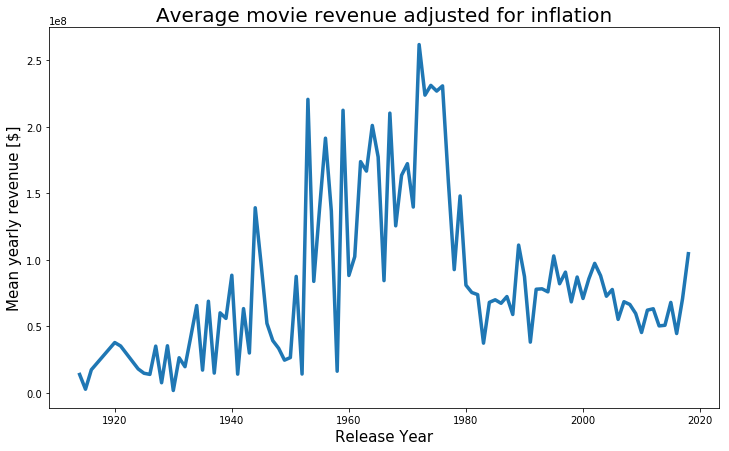

In [53]:
# pandas apply is very slow, so again
data['revenue_adjusted'] = (data['revenue'].map(lambda x: [x]) + data['release_year'].map(lambda x: [x])).map(
    lambda revenue_year: cpi.inflate(value=revenue_year[0], year_or_month=revenue_year[1], to=2018))

mean_yearly_revenues_adjusted = data[data['dataset'] == 'Train'].groupby('release_year', as_index=False)['revenue_adjusted'].agg(np.nanmean)

plt.figure(figsize=(12, 7))
plt.plot(mean_yearly_revenues_adjusted['release_year'], mean_yearly_revenues_adjusted['revenue_adjusted'], linewidth=3.5)
plt.xlabel('Release Year', fontsize=15)
plt.ylabel('Mean yearly revenue [$]', fontsize=15)
plt.title('Average movie revenue adjusted for inflation', fontsize=20)
data.drop('revenue_adjusted', axis=1, inplace=True)

Now the plot tells completely different story!


It might be interesting to read

[Why The 70's Were The Greatest Decade In America Cinema](https://medium.com/@jtesterkamp/new-hollywood-why-the-70s-were-the-greatest-decade-in-america-cinema-c42676e2170f), and 

[Were the 1950s a good decade for Hollywood cinema? (reddit)](https://www.reddit.com/r/TrueFilm/comments/39hf7u/were_the_1950s_a_good_decade_for_hollywood_cinema/cs3q208/)

In [54]:
%%HTML
<img src=http://filmsplusmovies.com/wp-content/uploads/2014/06/317-hollywood.jpg width="500">

Now, let us transform revenues to log scale.

In [55]:
data['budget_log'] = data['budget'].map(np.log1p)
data['revenue'] = data['revenue'].map(np.log1p)

### Sparse categorical features based on columns like crew, cast, etc.
Let's derive crew-based features. First, let us select jobs documented for more than half of movies.

Text(0.5, 0, 'Percentage of movies having the job in a crew team [%]')

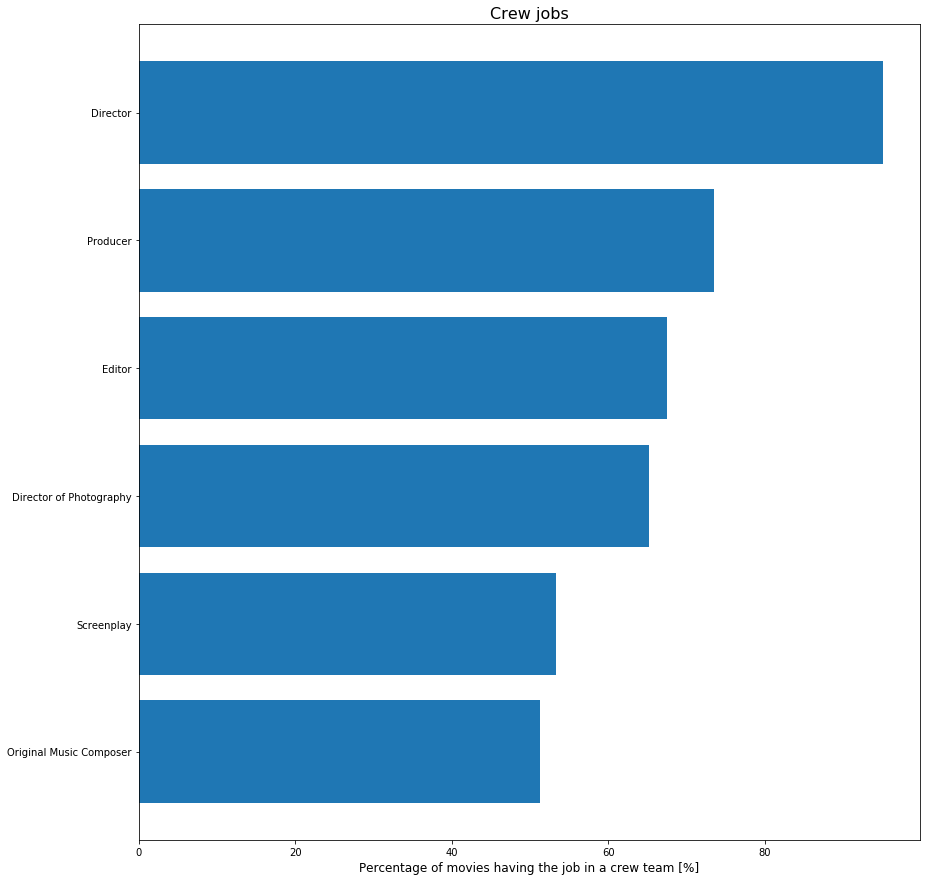

In [56]:
all_crew_job_movies = pd.Series(reduce(lambda list1, list2: list1 + list2, 
                                        data['crew'].map(lambda x: list(set(map(lambda el: el['job'], x)))).values))
plt.figure(figsize=(14, 15))
number_of_movies_with_job = all_crew_job_movies.value_counts().sort_values(ascending=False)
percentege_of_movies_with_job = 100 * number_of_movies_with_job / len(data)
top_frequent_jobs = percentege_of_movies_with_job[percentege_of_movies_with_job > 50].sort_values()
plt.barh(top_frequent_jobs.index, top_frequent_jobs)
plt.title('Crew jobs', fontsize=16)
plt.xlabel('Percentage of movies having the job in a crew team [%]', fontsize=12)

Let us estimate how many persons might be on a particular position in the same movie.

In [57]:
jobs_of_interest_set = set(top_frequent_jobs.index)

def value_counts_in_list(input_list):
    counts = defaultdict(int)
    for val in input_list:
        counts[val] += 1
    return list(counts.items())
job_person_counts = pd.Series(reduce(lambda list1, list2: list1 + list2, 
                                        data['crew'].map(lambda x: value_counts_in_list(
                                            filter(lambda x: x in jobs_of_interest_set, 
                                                   map(lambda el: el['job'], 
                                                       x)
                                        ))).values))
job_head_counts_df = pd.DataFrame({'job': job_person_counts.map(lambda x: x[0]), 'headcount': job_person_counts.map(lambda x: x[1])})
percentile_95_job_headcount = job_head_counts_df.groupby('job')['headcount'].quantile(0.95).map(int)
percentile_95_job_headcount[top_frequent_jobs.index]

Original Music Composer    2
Screenplay                 3
Director of Photography    1
Editor                     2
Producer                   5
Director                   2
Name: headcount, dtype: int64

*for each position there are only 5% of movies with higher headcounts*


Let us now engeer features. 

In [58]:
columns_len_init = len(data.columns)
# def return_job_names(crew, job_name):
#     headcount = percentile_95_job_headcount[job_name]
#     if not isinstance(crew, list) and np.isnan(crew):
#         return np.full(headcount, fill_value=np.nan)
#     names_generator = (el['name'] for el in crew if el['job'] == job_name)
#     results = np.empty(headcount, dtype='object')
#     for i in range(headcount):
#         results[i] = next(names_generator, np.nan)
#     return results

# for crew_col in top_frequent_jobs.index:
#     new_col_names = [f'{crew_col}_{i + 1}' for i in range(percentile_95_job_headcount[crew_col])]
#     df_added_cols = pd.DataFrame(np.column_stack(data['crew'].map(lambda x: return_job_names(x, crew_col))).T, columns=new_col_names, index=data.index)
#     data = pd.concat((data, df_added_cols), axis=1)

I decided not to do it like this. Motivation: both *Green Book* and comedies like *Dumb and Dumber To* would have Peter Farrelly as director 1. However, the solo *Green Book* is completely different from results of Peter Farrelly & Bobby Farrelly tandem. I might be "overfitted" based on a small number of cases, but I feel like a tandem of directors is a creative force different from each solo person. I would create concatenated entries.

For any job with ``percentile_95_job_headcount[job] > 2`` let us just do dummification with each person for the job resulting into a new dummy variable. Motivation to omit ordering from TMDB for high-cardinality positions: there are many actors in a movie. As a fan, I would like to see the movie due to particular actor. However, it doesn't really matter to me if the actor is listed as the first one on TMDB or as the 7th one. Again, this might be overfitted to my "domain intuition" and should be experimented with. 

In [59]:
# field to use for counting (there should not be any missing values in the feature)
print(data.isnull().sum().sort_values()[:1])
count_col = data.isnull().sum().sort_values().index[0]

Keywords    0
dtype: int64


In [60]:
def return_joint_entry(crew, job_name, sep='^'):
    headcount = percentile_95_job_headcount[job_name]
    if not isinstance(crew, list) and np.isnan(crew):
        return np.nan
    names = [el['name'] for el in crew if el['job'] == job_name][:headcount]
    return sep.join(names)

for crew_col in top_frequent_jobs.index:
    data[crew_col] = data['crew'].map(lambda x: return_joint_entry(x, crew_col))
    
jobs_to_dummify = [job for job in top_frequent_jobs.index if percentile_95_job_headcount[job] > 2]
final_dummy_cols = []

def get_number_of_movies_with_name(pd_series, sep='^'):
    names_in_movies = pd.Series(reduce(lambda list1, list2: list1 + list2,
                                       pd_series.map(lambda x: x.split(sep)).values))
    number_of_movies_with_name = names_in_movies.value_counts()
    return number_of_movies_with_name
    
for crew_col in jobs_to_dummify:
    number_of_movies_with_name = get_number_of_movies_with_name(data[crew_col])
    number_of_movies_with_name_train = get_number_of_movies_with_name(data.loc[data['dataset'] == 'Train', crew_col])
    # to have a personal feature, there must be at least 15 movies in total and at least 7 movies in train
    remaining_names = set(number_of_movies_with_name.index[number_of_movies_with_name >= 15]).intersection(
        set(number_of_movies_with_name_train.index[number_of_movies_with_name_train >= 7]))
    df_added_cols = data[crew_col].map(lambda x: '^'.join([name for name in x.split('^') if name in remaining_names])).str.get_dummies(sep='^')
    df_added_cols.columns = [f'{crew_col}_{value}' for value in df_added_cols.columns]
    final_dummy_cols.extend(df_added_cols.columns)
    data = pd.concat((data, df_added_cols), axis=1)
data.drop(jobs_to_dummify + ['crew'], axis=1, inplace=True)
                          
jobs_joint = [job for job in top_frequent_jobs.index if percentile_95_job_headcount[job] <= 2]

def hide_rare_values(data, column, overall_limit=7, train_limit=3):
    counts_total = data.groupby(joint_col)[count_col].count()
    counts_train = data[data['dataset']=='Train'].groupby(joint_col)[count_col].count()
    names_to_forget = set(counts_total[counts_total < overall_limit].index).union(set(counts_train[counts_train < train_limit].index))
    data.loc[data[joint_col].isin(names_to_forget), joint_col] = np.nan
    return data

for joint_col in jobs_joint:
    data = hide_rare_values(data, joint_col)

Let us create features from raw columns ``['cast', 'Keywords', 'genres', 'production_companies', 'production_countries', 'spoken_languages']``. I would create a joint feature for genres. For the rest let us perform the dummification.

In [61]:
def return_entries(list_dicts, sep='^'):
    if not isinstance(list_dicts, list) and np.isnan(list_dicts):
        return np.nan
    entries = [el['name'] for el in list_dicts]
    return sep.join(entries)

data['genres'] = data['genres'].map(return_entries)
data = hide_rare_values(data, 'genres', overall_limit=50, train_limit=20)

for dict_col in ['cast', 'Keywords', 'production_companies', 'production_countries', 'spoken_languages']:
    data[dict_col] = data[dict_col].map(return_entries)    
    names_in_movies = pd.Series(reduce(lambda list1, list2: list1 + list2,
                                       data[dict_col].map(lambda x: x.split('^')).values))
    number_of_movies_with_name = names_in_movies.value_counts()
    # minimal number of movies to have a feature
    min_movie_count = 20 if dict_col == 'cast' else 100 
    remaining_names = number_of_movies_with_name.index[number_of_movies_with_name >= min_movie_count]
    df_added_cols = data[dict_col].map(lambda x: '^'.join([name for name in x.split('^') if name in remaining_names])).str.get_dummies(sep='^')
    df_added_cols.columns = [f'{dict_col}_{value}' for value in df_added_cols.columns]
    final_dummy_cols.extend(df_added_cols.columns)
    data = pd.concat((data, df_added_cols), axis=1)
data.drop(['cast', 'Keywords', 'production_companies', 'production_countries', 'spoken_languages'], axis=1, inplace=True)

### Textual features

In [62]:
porter = PorterStemmer()

def get_listofwords_series(col):
    # mapping to str is performed so that missing values become 'nan' strings
    all_list_of_words_series = data[col].map(str).map(lambda text: [porter.stem(w) if w != 'nan' else np.nan for w in word_tokenize(text.translate(str.maketrans('','',string.punctuation)).lower())])
    if f'{col}_stopwords_count' not in data.columns:
        data[f'{col}_stopwords_count'] =  all_list_of_words_series.map(lambda x: sum([w in stopwords_eng for w in x]))
        data[f'{col}_stopwords_fraction'] = data[f'{col}_stopwords_count']/all_list_of_words_series.map(len)
    return all_list_of_words_series.map(lambda all_words: list(filter(lambda x: x not in stopwords_eng, all_words)))

Let us remove rare words. First, we would visualize frequencies of words. 

In [63]:
def get_percentege_of_movies_with_word(col):
    listofwords_series = get_listofwords_series(col)
    word_movies_count = pd.Series(reduce(lambda list1, list2: list1 + list2, listofwords_series.map(lambda x: list(set(x))).values)).value_counts()
    percentege_of_movies_with_word = 100 * word_movies_count.sort_values(ascending=False) / len(data)
    return percentege_of_movies_with_word

def visualize_rank_freq(col, number_of_top_words_to_check=30):
    percentege_of_movie_with_word = get_percentege_of_movies_with_word(col)
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 24))
    for rank, movies_percentage in enumerate(percentege_of_movie_with_word[:number_of_top_words_to_check]):
        ax1.scatter(rank + 1, movies_percentage, s=200*len(percentege_of_movie_with_word.index[rank]), 
                    marker=r"$ {} $".format(percentege_of_movie_with_word.index[rank]))
    ax1.set_xlabel('Rank', fontsize=14)
    ax1.set_ylabel('Percentage of movies [%]', fontsize=14)
    ax1.set_title(f'{number_of_top_words_to_check} the most frequent words in {col}', fontsize=19)

    for percentile in np.arange(0, 100, 0.1):
        ax2.scatter(percentile, percentege_of_movie_with_word[int(round(len(percentege_of_movie_with_word)*percentile/100))])
    ax2.set_xlabel('Rank percentile', fontsize=14)
    ax2.set_ylabel('Percentage of movies [%]', fontsize=14)
    ax2.set_title(f'Words in {col}', fontsize=19)
    
def add_word_columns(data, col, percentege_of_movie_with_word_lb=0.01, percentege_of_movie_with_word_ub=0.4):
    percentege_of_movie_with_word = get_percentege_of_movies_with_word(col)
    words_to_use = set(percentege_of_movie_with_word.index[(percentege_of_movie_with_word > percentege_of_movie_with_word_lb) & 
                                                         (percentege_of_movie_with_word < percentege_of_movie_with_word_ub)])
    listwords_series = get_listofwords_series(col).map(lambda x: [word for word in x if word in words_to_use])
    word_columns_count = int(listwords_series.map(len).quantile(0.95))
    listwords_series = listwords_series.map(lambda x: x[:word_columns_count] if len(x) >= word_columns_count else x + np.full(word_columns_count - len(x), np.nan).tolist())
    added_columns = pd.DataFrame(np.column_stack(listwords_series).T, columns=[f'{col}_word_{i}' for i in range(1, word_columns_count + 1)], index=data.index)
    added_columns[added_columns == 'nan'] = np.nan # as we used a numpy for the intermediate step
    data = pd.concat((data, added_columns), axis=1)
    return data

#### Title

"[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table." Let us see it in our case**.

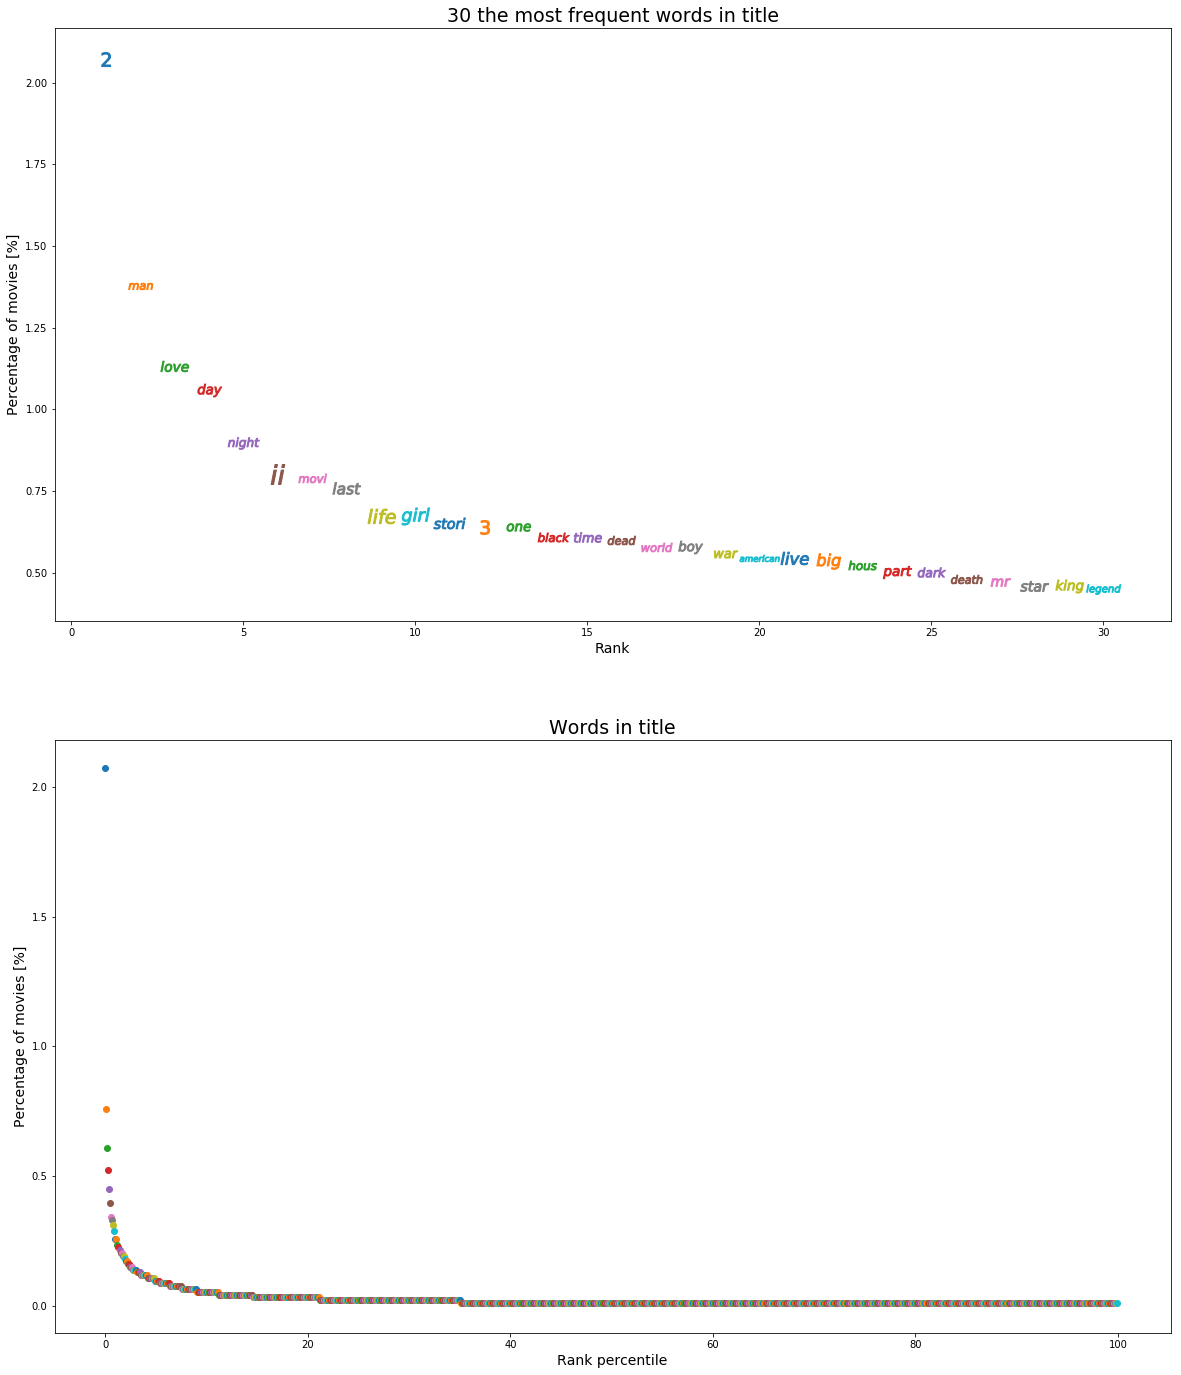

In [64]:
visualize_rank_freq('title')

There are more sequels than movies with word "love" in the title :) It reminds me of a line from the funny [Epic Rap Battle between movie directors](https://www.youtube.com/watch?v=_wYtG7aQTHA): *"Got no time to read reviews while I'm working on the sequel!"*

---------
Due to the observed low percentages of movies with a particular word in the title, I would not introduce any features based on titles.

#### Overview and tagline

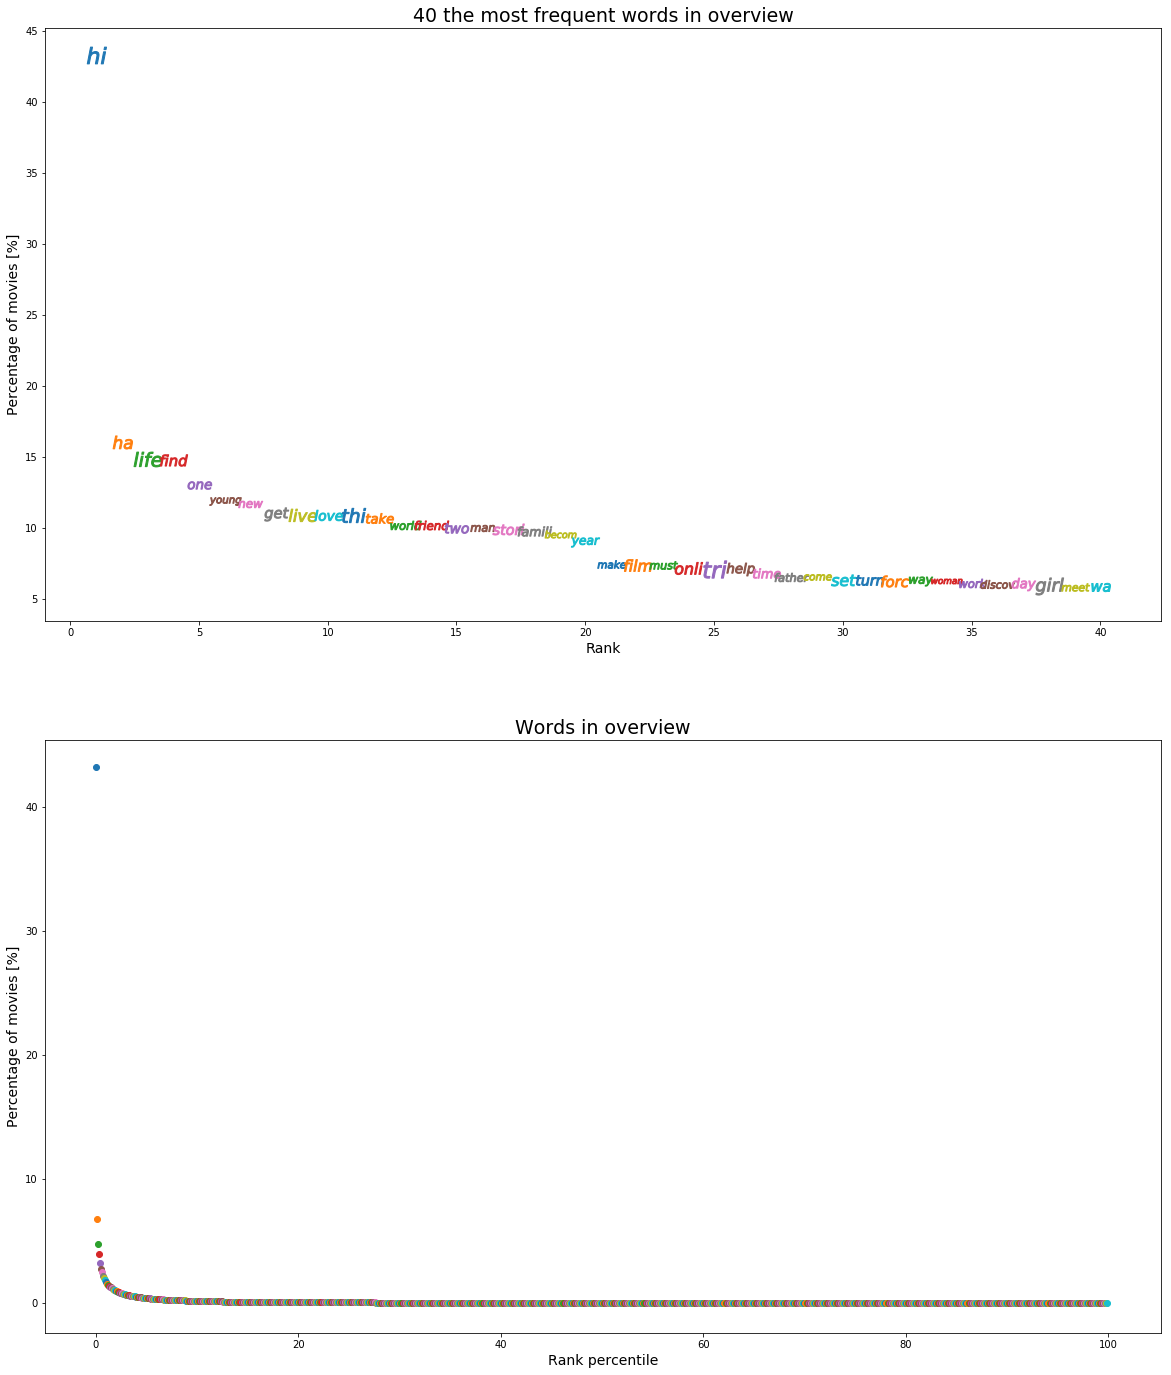

In [65]:
visualize_rank_freq('overview', number_of_top_words_to_check=40)

In [66]:
data = add_word_columns(data, 'overview')

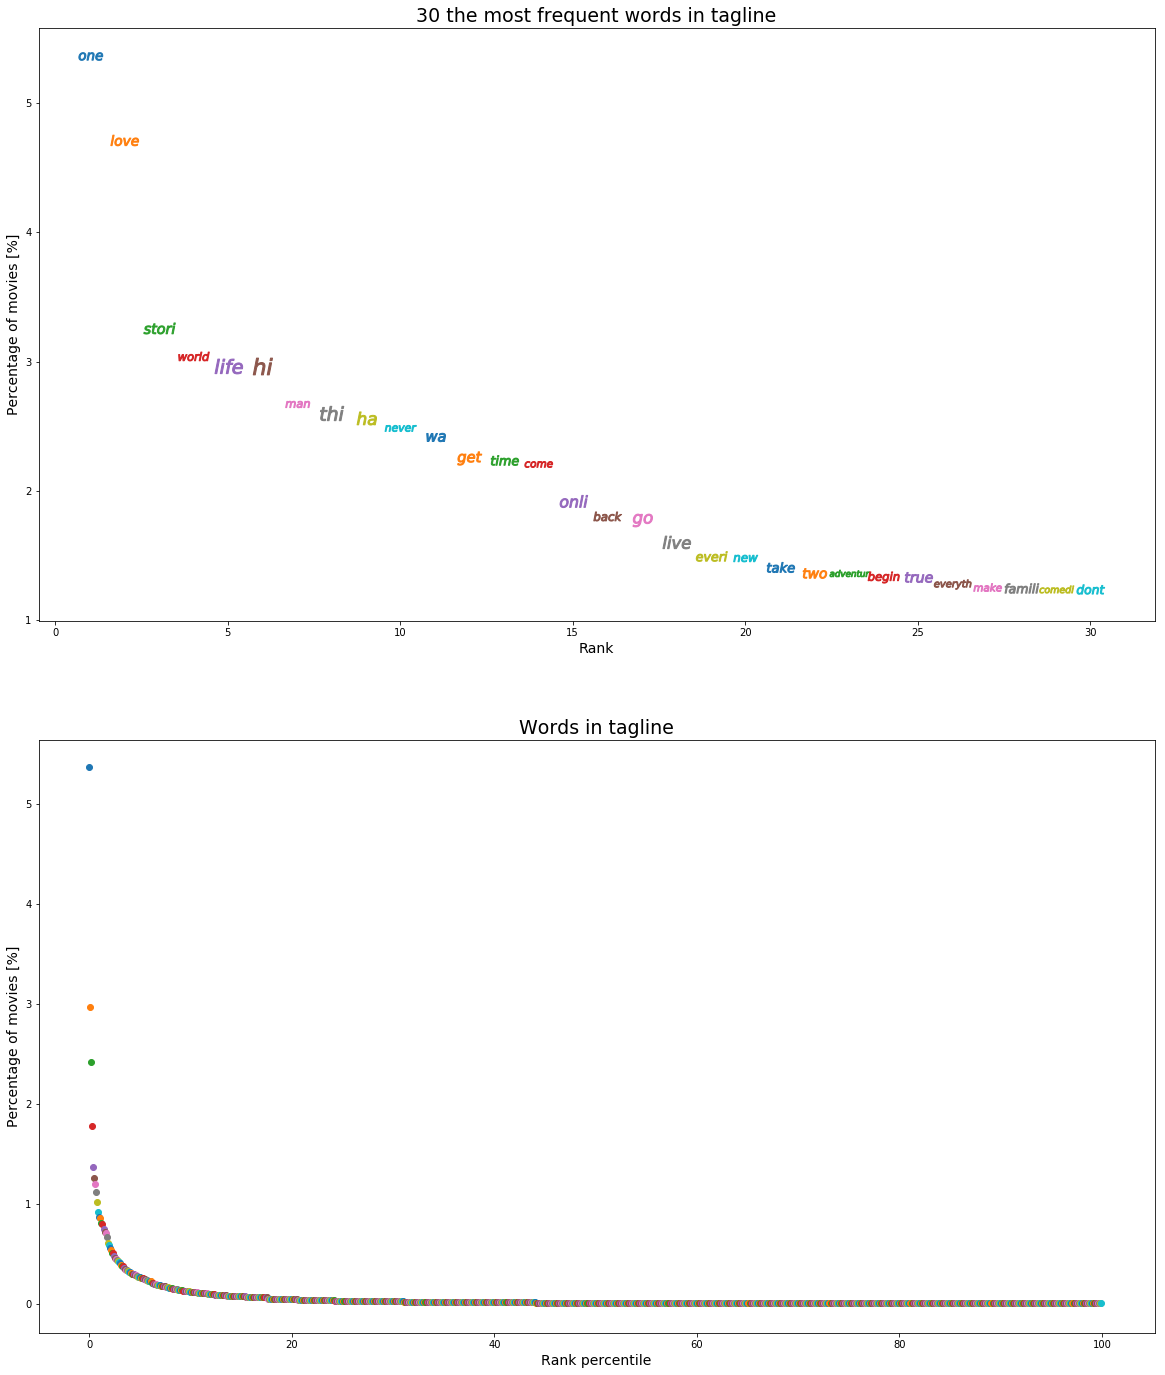

In [67]:
visualize_rank_freq('tagline')

In [68]:
%%HTML
<img src=https://mindblown.smumn.edu/wp-content/uploads/2018/02/zipf-law-meme.jpg width="200">

In [69]:
data = add_word_columns(data, 'tagline')

In [70]:
data.drop(['title', 'original_title', 'overview', 'tagline'], axis=1, inplace=True)

### Features based on competition
Let us derive features which would compare a movie with other pictures likely shown in cinemas simultaneously with the movie.

In [71]:
def compute_stats(val_date, competition_values_all):
    movie_val = val_date[0]
    movie_competition_groupy_id_date = val_date[1]
    if np.isnan(movie_val) or pd.isnull(movie_competition_groupy_id_date):
        return [np.nan] * 6
    competition = competition_values_all[movie_competition_groupy_id_date]
    zscore = (movie_val - np.nanmean(competition))/np.nanstd(competition)
    percentile = stats.percentileofscore(competition, movie_val)
    val_to_max = movie_val / np.nanmax(competition)
    min_to_val = np.nanmin(competition) / movie_val  
    val_to_mean = movie_val / np.nanmean(competition)
    val_to_median = movie_val / np.nanmedian(competition)
    return [zscore, percentile, val_to_max, min_to_val, val_to_mean, val_to_median]

def add_comparison_stats(data, cols, neighbourhood_in_weeks=1):
    
    def get_next_sunday_date(date):
        # as we use closed='right', group release date is the first Sunday after the period
        return date + pd.to_timedelta(6 - date.weekday() % 7, unit='D')
    
    time_range_groups = None
    dummy_release_dates = []
    for i in range(2*neighbourhood_in_weeks):
        # we add a dummy row with all nans to manipulate resample-like functionality of pandas.Grouper so that groups for each week are introduced. Dummy nans are filtered during aggregation
        ts_dummy = data.loc[~data['release_date'].isin(dummy_release_dates), 'release_date'].min() - pd.to_timedelta(i * 1, unit='W')
        dummy_row = pd.DataFrame([np.full_like(data.iloc[0], fill_value=np.nan)], columns=data.columns)
        dummy_row['release_date'] = ts_dummy
        if i > 0: # when i == 0, ts_dummy is equal to the earliest actual timestamp
            dummy_release_dates.append(ts_dummy)
        data = pd.concat((data, dummy_row))
        groups_next = (data[['release_date'] + cols]
                       .groupby(pd.Grouper(key='release_date', freq=f'{2*neighbourhood_in_weeks}W', closed='right'))
                       .agg(lambda values: list(filter(lambda val: not np.isnan(val), values))))
        time_range_groups = groups_next if time_range_groups is None else pd.concat((time_range_groups, groups_next))

    for col in cols:   
        competition_values = time_range_groups[col]
        # computing date identifying the competition time range for particular movie, and, again, avoiding the slow apply by using map on a series of two-element list
        val_date_series = data[col].map(lambda x: [x]) + (data['release_date']
                                                          .map(lambda x: x + pd.to_timedelta(neighbourhood_in_weeks, unit='W'))
                                                          .map(get_next_sunday_date)
                                                          .map(lambda x: [x]))
        column_names = [f"{col}_competition_{stat}_±_{neighbourhood_in_weeks}_week{'s' if neighbourhood_in_weeks > 1 else ''}" for stat in ['zscore', 'percentile', 'val_to_max', 'min_to_val', 'val_to_mean', 'val_to_median']]
        df_added_cols = pd.DataFrame(np.column_stack(val_date_series.map(lambda val_date: compute_stats(val_date, competition_values))).T, columns=column_names, index=data.index)
        data = pd.concat((data, df_added_cols), axis=1)
    return data

In [72]:
data = add_comparison_stats(data, cols=['rating', 'totalVotes', 'budget', 'runtime', 'popularity_mean'])
data = add_comparison_stats(data, cols=['rating', 'totalVotes', 'budget', 'popularity_mean'], neighbourhood_in_weeks=2)

#### Final cleaning of columns

In [73]:
print(f"Each movie belongs to {data['belongs_to_collection'].map(lambda x: 0 if not isinstance(x, list) else len(x)).max()} collection(s) at most.")

Each movie belongs to 1 collection(s) at most.


In [74]:
data.drop('belongs_to_collection', axis=1, inplace=True)
data['collection_id'] = data['collection_id'].astype('object')

In [75]:
data.drop(['homepage', 'id', 'imdb_id', 'poster_path', 'release_date', 'budget_cat'], axis=1, inplace=True)

## Modeling

### Field-Aware Factorization Machines (not promising performance for the task, please check out the later kernel versions)
Perhaps, someone might find useful an introductory video by [Yuchin Juan](https://www.kaggle.com/guestwalk), one of the authors.

In [76]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/1cRGpDXTJC8?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>

Let us inspire with [libffm kernel](https://www.kaggle.com/scirpus/libffm-generator-lb-280) by [Scirpus](https://www.kaggle.com/scirpus). Things we are going to do differently:
* quatile-based discretization of numerical features,
* we would additionally discard only-train/only-test values,
* we would write custom conversion to libffm data format based on the library documentation.

In [77]:
# categorical_columns = []
# numerical_columns = []
# for col, col_type in zip(data.columns, data.dtypes):
#     if col == 'dataset':
#         continue
#     if col_type==np.dtype('O') or col in final_dummy_cols:
#         categorical_columns.append(col)
#     else:
#         numerical_columns.append(col)

Some numerical columns are categorical flags.

In [78]:
# flag_cols = ['has_homepage',
#              'isbelongs_to_collectionNA',
#              'isTaglineNA',
#              'isOriginalLanguageEng',
#              'isTitleDifferent',
#              'isMovieReleased']
# numerical_columns = [col for col in numerical_columns if col not in flag_cols]
# categorical_columns.extend(flag_cols)
# numerical_columns.remove('revenue')

Discretization of numerical features. 

In [79]:
# data_ffm = deepcopy(data)
# for col in numerical_columns:
#     if col != 'release_year':
#         # + 1 so that in all columns missing value corresponds to 0, 
#         # reminder: libffm requires non-negative integers and having non-negative ints here would help us during encoding into libffm format
#         data_ffm[col] = pd.qcut(data_ffm[col], q=200, duplicates='drop', labels=False).factorize()[0] + 1 
# for col in categorical_columns:
#     data_ffm[col] = data_ffm[col].factorize()[0] + 1

# # there is no need to lear embeddings for values not present in the test
# # and as for the test set, value not encounted during training is equivalent to missing
# train_logical_indexing = data_ffm['dataset']=='Train'
# test_logical_indexing = data_ffm['dataset']=='Test'
# for col in [num_col for num_col in numerical_columns if num_col != 'release_year'] + [cat_col for cat_col in categorical_columns if cat_col != 'dataset']:
#     train_values = set(data_ffm.loc[train_logical_indexing, col].values)
#     test_values = set(data_ffm.loc[test_logical_indexing, col].values)
#     values_to_preserve = train_values.intersection(test_values)
#     data_ffm.loc[~data_ffm[col].isin(values_to_preserve), col] = 0 # corresponds to missing values, see above

We have previously verified that stratification by year leads to reasonable mimicking of the train/test split. Let's do it.

In [80]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_folds = [[trn_idx, val_idx] for trn_idx, val_idx in skf.split(list(range((data_ffm['dataset'] == 'Train').sum())), 
#                                                                  data_ffm.loc[data_ffm['dataset'] == 'Train', 'release_year'])]
# data_ffm['release_year'] = data_ffm['release_year'].factorize()[0]
# train_ffm = data_ffm[data_ffm['dataset'] == 'Train'].drop('dataset', axis=1)
# test_ffm = data_ffm[data_ffm['dataset'] == 'Test'].drop('dataset', axis=1)

Converting data to libffm format as specified in [libffm README](https://github.com/guestwalk/libffm/blob/master/README).

In [81]:
# accumulated_count = 0
# dict_feature = dict()
# for col in numerical_columns + categorical_columns:
#     for val in data_ffm[col].unique():
#         dict_feature[(col, val)] = accumulated_count + val
#     accumulated_count += data_ffm[col].nunique()
    
# def produce_file(file_name, df_to_process, test=False):
#         noofrows = df_to_process.shape[0]
#         noofcolumns = df_to_process.shape[1]
#         currentcode = len(numerical_columns)
#         with open(file_name, 'w') as text_file:
#             for n, r in enumerate(tqdm(range(noofrows), desc=file_name)):
#                 datastring = ''
#                 datarow = df_to_process.iloc[r]
#                 if not test:
#                     datastring += str(datarow['revenue'])
#                 else:
#                     datastring += '10'

#                 for col_i, col in enumerate(numerical_columns + categorical_columns):
#                     datastring = f'{datastring} {col_i}:{dict_feature[(col, datarow[col])]}:1'
#                 datastring += '\n'
#                 text_file.write(datastring)
                
# def create_train_val_files(train_ffm, val_ffm, test_ffm=test_ffm, fold_idx=0, dict_feature=dict_feature):   
#     produce_file(f'train_ffm_{fold_idx}', train_ffm)                
#     produce_file(f'val_ffm_{fold_idx}', val_ffm) 

# produce_file('test_ffm', test_ffm, test=True)

Installing [a branch of LIBFFM for regression problems](https://github.com/bobye/libffm-regression).

In [82]:
# # capturing subprocess output line by line: https://stackoverflow.com/questions/4417546/constantly-print-subprocess-output-while-process-is-running
# def execute_generator(cmd):
#     popen = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, universal_newlines=True)
#     for stdout_line in iter(popen.stdout.readline, ""):
#         yield stdout_line 
#     popen.stdout.close()
#     return_code = popen.wait()
#     if return_code:
#         raise subprocess.CalledProcessError(return_code, cmd)
        
# def execute(cmd, parse_val_result=False):
#     # for local cross validation we would like to parse validation score
#     all_lines = []
#     for path in execute_generator(cmd):
#         print(path, end="")
#         all_lines.append(path)
#     if parse_val_result:
#         words_in_lines = [line.split() for line in all_lines]
#         the_last_row_to_use = False
#         try:
#             val_score = float(words_in_lines[-1][-1])
#             the_last_row_to_use = True
#         except ValueError: pass
#         if the_last_row_to_use:
#             return val_score
#         # otherwise, the last line must be something like Auto-stop. Use model at 7th iteration. So we need the 3rd line from the end
#         return float(words_in_lines[-3][-1])       
        
# execute('git clone https://github.com/bobye/libffm-regression')
# with open('libffm-regression/ffm-predict.cpp', 'r') as file:
#     prediction_code = file.readlines()
# # I had problems with ffm-predict command: it was outputting several GB of floats on each run. This modification helped
# prediction_code[84] = '        ffm_float t = ffm_predict(x.data(), x.data()+x.size(), model, false);\n'
# with open('libffm-regression/ffm-predict.cpp', 'w') as file:
#     file.writelines(prediction_code)
# os.chdir('libffm-regression')
# execute('make')
# os.chdir('..')

Training with early stopping, then predicting on test.

Let us calculate an interval estimate for the model performance. Please note that in general there is a rule of thumb that one should not compute t-interval for sample mean unless there are at least 30 randomly picked samples. The reason for this rule of thumb is that due to central limit theorem, sample mean would be normally distributed for large enough sample no matter what population distribution was. And the commonly used threshold of 30 is an empirical way to check that the sample is large enough. In our case we perform 5-fold CV, therefore we have only 5 samples. However, I would assume that distribution of the model rmsle is normal itself, which results in normal distribution of sample mean. Please, let me know if I might be missing some reasons for it not to be true (the folds are shuffled :)).

In [83]:
# submission_ffm = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
# submission_ffm['revenue'] = 0
# cv_rmsle_scores = []
# for fold_idx, (trn_idx, val_idx) in enumerate(cv_folds):
#     print('='*40)    
#     print('='*16 + f' FOLD {fold_idx} ' + '='*16)
#     train_ffm_trn = train_ffm.iloc[trn_idx]
#     train_ffm_val = train_ffm.iloc[val_idx]
#     create_train_val_files(train_ffm_trn, train_ffm_val, fold_idx=fold_idx)
#     val_score = execute(f'libffm-regression/ffm-train -p val_ffm_{fold_idx} --auto-stop -t 30 train_ffm_{fold_idx} model_{fold_idx}', parse_val_result=True)
#     print(f'Val score: {val_score}')
#     cv_rmsle_scores.append(val_score)
#     os.remove(f'val_ffm_{fold_idx}')
#     os.remove(f'train_ffm_{fold_idx}')
#     execute(f'libffm-regression/ffm-predict test_ffm model_{fold_idx} output_{fold_idx} > /dev/null')
#     predictions_current = pd.read_csv(f'output_{fold_idx}',header=None)
#     os.remove(f'output_{fold_idx}')
#     os.remove(f'model_{fold_idx}')
#     predictions_current.columns = ['revenue']
#     submission_ffm['revenue'] += predictions_current['revenue']/len(cv_folds)

# # cleaning up
# rmtree('libffm-regression')
# os.remove('test_ffm')

# # performance estimation
# rmsle_mean = np.mean(cv_rmsle_scores)
# rmsle_mean_std = np.std(cv_rmsle_scores, ddof=1)/np.sqrt(len(cv_rmsle_scores))
# tinteval_lb, tinterval_ub = _tconfint_generic(rmsle_mean, rmsle_mean_std, dof=len(cv_rmsle_scores)-1, alpha=0.05, alternative='two-sided')
# print(f"95% confidence interval for RMSLE is: ({tinteval_lb:.2f}, {tinterval_ub:.2f}).")

# # transforming revenues back to $
# submission_ffm['revenue'] = submission_ffm['revenue'].map(np.expm1)
# submission_ffm.to_csv('submission_ffm.csv', index=None)

### LightGBM

For Bayesian optimization of hyperparameters we're going to reuse some pieces from the great workshop from Luca Massaron and Pietro Marinelli I was lucky to attend during the second edition of KaggleDays, January 2019. 

In [84]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/mg7BNAvHeII?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>

I'm not going to tune the number of estimators as a hyperparameter, rather I'll define early stopping inside the objective. Also, for each categorical column based on word let's leave only values which occur at least 10 times.

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_data = data[data['dataset'] == 'Train']
y_train = train_data['revenue']
cv_folds = [[trn_idx, val_idx] for trn_idx, val_idx in skf.split(list(range(len(train_data))), train_data['release_year'])]

def hide_rare_vals(data, categorical_columns, min_count=2):
    for col in categorical_columns:
        data['count'] = np.arange(len(data))
        value_counts = data.groupby(col, as_index=False)['count'].count()
        values_to_discard = set(value_counts.loc[value_counts['count'] < min_count, col].values)
        data.loc[data[col].isin(values_to_discard), col] = np.nan
        data.drop('count', axis=1, inplace=True)
    return data

categorical_columns = [col for col, col_type in zip(data.columns, data.dtypes) if col_type==np.dtype('O') and col != 'dataset']
data_for_boosting = hide_rare_vals(data, 
                                   [col for col in categorical_columns if 'word' in col], 
                                   min_count=10)
data_for_boosting = hide_rare_vals(data_for_boosting, 
                                   [col for col in categorical_columns if not 'word' in col])
    
data_one_hot_enc = pd.get_dummies(data_for_boosting.drop(['revenue'], axis=1),
                                  columns=categorical_columns)
train_one_hot_enc = data_one_hot_enc[data_one_hot_enc['dataset'] == 'Train'].drop(['dataset'], axis=1)

In [86]:
counter = 0
def onstep(res):
    global counter
    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('Current iter: ', counter, 
          ' - Score ', res.fun, 
          ' - Args: ', res.x)
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1
              
# The objective function to be minimized
def make_objective(model, dimensions, df=data):
    model = deepcopy(model)

    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    @use_named_args(dimensions) 
    def objective(**params):
        model.set_params(**params)
        score = 0
        for trn_idx, val_idx in cv_folds:
            X_fit, X_val = df.iloc[trn_idx], df.iloc[val_idx]
            y_fit, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]
            model.fit(X_fit, y_fit,
                      eval_set=[(X_val, y_val)],
                      verbose=False, early_stopping_rounds=30)
            score += get_rmsle(y_val, model.predict(X_val), X_val['release_year'])/len(cv_folds)              
        return score
    
    return objective

In [87]:
# result of the offline optimization
skopt_params = {'learning_rate': 0.0009, 'num_leaves': 2558, 'max_depth': 0, 'min_child_samples': 15, 'max_bin': 95637, 'subsample': 0.4462883478742228, 'subsample_freq': 0, 'colsample_bytree': 0.12636976300879604, 'min_child_weight': 1, 'subsample_for_bin': 422967, 'reg_lambda': 8.991454050632966e-05, 'reg_alpha': 0.000956883899855844, 'scale_pos_weight': 0.000511057873147196}
if skopt_params is None:
    clf = LGBMRegressor(boosting_type='gbdt',
                        objective='rmse',
                        n_jobs=-1,
                        verbose=0,
                        n_estimators=10000, 
                        bin_construct_sample_cnt=100000,
                        min_data=50)

    dimensions = [Real(0.01, 1.0, 'log-uniform', name='learning_rate'),
                  Integer(100, 10000, name='num_leaves'),
                  Integer(0, 500, name='max_depth'),
                  Integer(0, 200, name='min_child_samples'),
                  Integer(100, 100000, name='max_bin'),
                  Real(0.01, 1.0, 'uniform', name='subsample'),
                  Integer(0, 10, name='subsample_freq'),
                  Real(0.01, 1.0, 'uniform', name='colsample_bytree'),
                  Integer(0, 10, name='min_child_weight'),
                  Integer(100000, 500000, name='subsample_for_bin'),
                  Real(1e-9, 1000, 'log-uniform', name='reg_lambda'),
                  Real(1e-9, 1.0, 'log-uniform', name='reg_alpha'),
                  Real(1e-6, 500, 'log-uniform', name='scale_pos_weight')]

    objective = make_objective(clf, dimensions, train_one_hot_enc)

    gp_round = gp_minimize(func=objective,
                           dimensions=dimensions,
                           acq_func='gp_hedge', 
                           n_calls=50,
                           callback=[onstep],
                           random_state=42)
    best_parameters = gp_round.x
    best_result = gp_round.fun
    skopt_params = {param.name: value for param, value in zip(dimensions, best_parameters)}
    print(f'Best RMSLE: {best_result},\ncorresponding parameters: {skopt_params}')

In [88]:
clfs = []
cv_rmsle_scores = []
importances = pd.DataFrame()
for fold_idx, (trn_idx, val_idx) in enumerate(cv_folds):
    clf = LGBMRegressor(boosting_type='gbdt',
                        objective='rmse',
                        num_leaves=5000,
                        n_jobs=-1,
                        verbose=1,
                        n_estimators=15000, 
                        bin_construct_sample_cnt=100000,
                        min_data=50)
    clf.set_params(**skopt_params)
    
    X_fit, X_val = train_one_hot_enc.iloc[trn_idx], train_one_hot_enc.iloc[val_idx]
    y_fit, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    clf.fit(X_fit, y_fit, eval_metric='rmse', 
                  eval_set=[(X_fit, y_fit), (X_val, y_val)], 
                  verbose=500, early_stopping_rounds=300)
    
    imp_df = pd.DataFrame({
                'feature': X_fit.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_idx + 1] * len(X_fit.columns),
                })
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    clfs.append(clf)
    cv_rmsle_scores.append(np.sqrt(mean_squared_error(y_val, clf.predict(X_val))))

# performance estimation
rmsle_mean = np.mean(cv_rmsle_scores)
rmsle_mean_std = np.std(cv_rmsle_scores, ddof=1)/np.sqrt(len(cv_rmsle_scores))
tinteval_lb, tinterval_ub = _tconfint_generic(rmsle_mean, rmsle_mean_std, dof=len(cv_rmsle_scores)-1, alpha=0.05, alternative='two-sided')
print(f"95% confidence interval for RMSLE is: ({tinteval_lb:.2f}, {tinterval_ub:.2f}).")

Training until validation scores don't improve for 300 rounds.
[500]	training's rmse: 3.02805	valid_1's rmse: 3.07422
[1000]	training's rmse: 2.50643	valid_1's rmse: 2.54213
[1500]	training's rmse: 2.20612	valid_1's rmse: 2.26516
[2000]	training's rmse: 2.02644	valid_1's rmse: 2.12941
[2500]	training's rmse: 1.90826	valid_1's rmse: 2.06366
[3000]	training's rmse: 1.82	valid_1's rmse: 2.03027
[3500]	training's rmse: 1.74805	valid_1's rmse: 2.01265
[4000]	training's rmse: 1.68474	valid_1's rmse: 2.00282
[4500]	training's rmse: 1.6273	valid_1's rmse: 1.99713
[5000]	training's rmse: 1.57363	valid_1's rmse: 1.99291
[5500]	training's rmse: 1.52284	valid_1's rmse: 1.98975
[6000]	training's rmse: 1.47528	valid_1's rmse: 1.98711
[6500]	training's rmse: 1.42975	valid_1's rmse: 1.98489
[7000]	training's rmse: 1.38678	valid_1's rmse: 1.98321
[7500]	training's rmse: 1.34568	valid_1's rmse: 1.98213
[8000]	training's rmse: 1.30663	valid_1's rmse: 1.98137
[8500]	training's rmse: 1.26913	valid_1's rmse

In [89]:
test_one_hot_enc = data_one_hot_enc[data_one_hot_enc['dataset'] == 'Test'].drop(['dataset'], axis=1)
submission_lgb = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
submission_lgb['revenue'] = 0
for clf in clfs:
    submission_lgb['revenue'] += np.expm1(clf.predict(test_one_hot_enc))/len(clfs)
submission_lgb.to_csv('submission_lgb.csv', index=None)